In [1]:
import os
# set wd to cancer
os.chdir("/work/postresearch/Shared/Researchers/Farbod/cancer/code/")
print(os.getcwd())

/work/postresearch/Shared/Researchers/Farbod/cancer/code


In [2]:
import os
import sys
import math
import copy
import logging
import requests
import zipfile
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from itertools import chain
from typing import Union

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor

from pytorch_lightning import LightningModule, Trainer
from omegaconf import DictConfig, OmegaConf
from omegaconf.errors import MissingMandatoryValue

import ray
from ray import tune, ray_constants

import hydra
from hydra import initialize, compose
from hydra.utils import instantiate

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

from IPython.core.interactiveshell import InteractiveShell

from src.data import RealDatasetCollection, SyntheticDatasetCollection
from src.models import TimeVaryingCausalModel
from src.models.utils import (
    grad_reverse,
    BRTreatmentOutcomeHead,
    AlphaRise,
    clip_normalize_stabilized_weights,
)
from src.models.utils_lstm import VariationalLSTM
from copy import deepcopy

InteractiveShell.ast_node_interactivity = "all"

In [3]:
# show pytorch version and cuda version
print(torch.__version__)
print(torch.version.cuda)

if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")
    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")
else:
    print("CUDA is not available. No GPUs detected.")

2.0.0+cu118
11.8
Number of available GPUs: 1
GPU 0: NVIDIA A100 80GB PCIe


## Collecting and preparing data


In [53]:
logger = logging.getLogger(__name__)


class CausalDiff(TimeVaryingCausalModel):

    model_type = None  # Will be defined in subclasses
    possible_model_types = {'msm_regressor',
                            'propensity_treatment', 'propensity_history'}

    def __init__(
        self,
        args: DictConfig,
        dataset_collection: Union[
            RealDatasetCollection, SyntheticDatasetCollection
        ] = None,
        autoregressive: bool = None,
        has_vitals: bool = None,
        projection_horizon: int = None,
        bce_weights: np.array = None,
        **kwargs
    ):
        """
        Args:args: DictConfig of model hyperparameters
            dataset_collection: Dataset collection
            autoregressive: Flag of including previous outcomes to modelling
            has_vitals: Flag of vitals in dataset
            projection_horizon: Range of tau-step-ahead prediction (tau = projection_horizon + 1)
            bce_weights: Re-weight BCE if used
            **kwargs: Other arguments
        """
        super().__init__(
            args, dataset_collection, autoregressive, has_vitals, bce_weights
        )

        if self.dataset_collection is not None:
            self.projection_horizon = self.dataset_collection.projection_horizon
        else:
            self.projection_horizon = projection_horizon

        self.lag_features = args.model.lag_features

    def prepare_data(self) -> None:
        if (
            self.dataset_collection is not None
            and not self.dataset_collection.processed_data_multi
        ):
            self.dataset_collection.process_data_multi()

    def get_exploded_dataset(self, dataset: Dataset, min_length: int, only_active_entries=True, max_length=None) -> Dataset:
        exploded_dataset = deepcopy(dataset)
        if max_length is None:
            max_length = max(exploded_dataset.data['sequence_lengths'][:])
        if not only_active_entries:
            exploded_dataset.data['active_entries'][:, :, :] = 1.0
            exploded_dataset.data['sequence_lengths'][:] = max_length
        exploded_dataset.explode_trajectories(min_length)
        return exploded_dataset

    def get_propensity_scores(self, dataset: Dataset) -> np.array:
        logger.info(f'Propensity scores for {dataset.subset_name}.')
        exploded_dataset = self.get_exploded_dataset(
            dataset, min_length=self.lag_features, only_active_entries=False)

        inputs = self.get_inputs(exploded_dataset)
        classifier = getattr(self, self.model_type)

        propensity_scores = np.stack(
            classifier.predict_proba(inputs), 1)[:, :, 1]
        propensity_scores = propensity_scores.reshape(dataset.data['active_entries'].shape[0],
                                                      dataset.data['active_entries'].shape[1] -
                                                      self.lag_features,
                                                      self.dim_treatments)
        propensity_scores = np.concatenate([0.5 * np.ones((propensity_scores.shape[0], self.lag_features, self.dim_treatments)),
                                            propensity_scores], axis=1)
        return propensity_scores

    # def get_propensity_scores(self, classifier, inputs, dataset: Dataset) -> np.array:
    #     logger.info(f'Propensity scores for {dataset.subset_name}.')

    #     propensity_scores = np.stack(
    #         classifier.predict_proba(inputs), 1)[:, :, 1]
    #     propensity_scores = propensity_scores.reshape(dataset.data['active_entries'].shape[0],
    #                                                   dataset.data['active_entries'].shape[1] -
    #                                                   self.lag_features,
    #                                                   self.dim_treatments)
    #     propensity_scores = np.concatenate([0.5 * np.ones((propensity_scores.shape[0], self.lag_features, self.dim_treatments)),
    #                                         propensity_scores], axis=1)
    #     return propensity_scores

In [5]:
# Load the configuration file
config_path = '/work/postresearch/Shared/Researchers/Farbod/cancer/code/config/dataset/cancer_sim.yaml'
args = OmegaConf.load(config_path)

# Instantiate the dataset collection
dataset_collection = instantiate(args.dataset, _recursive_=True)

  0%|          | 0/100 [00:00<?, ?it/s]

/work/postresearch/Shared/Researchers/Farbod/cancer/code/src/data/cancer_sim/cancer_simulation.py:346: RuntimeWarning: overflow encountered in exp
  if recovery_rvs[i, t] < np.exp(-cancer_volume[i, t] * TUMOUR_CELL_DENSITY):
100%|██████████| 100/100 [00:00<00:00, 239.77it/s]


Call to simulate counterfactuals data


 27%|██▋       | 27/100 [00:00<00:01, 49.89it/s]/work/postresearch/Shared/Researchers/Farbod/cancer/code/src/data/cancer_sim/cancer_simulation.py:734: RuntimeWarning: invalid value encountered in log
  (1 + rho * np.log(K / (counterfactual_cancer_volume[current_t] + 1e-07) + 1e-07) -
100%|██████████| 100/100 [00:01<00:00, 50.75it/s]


In [6]:
# Create an instance of CausalDiff
causal_diff = CausalDiff(args, dataset_collection)

# Test the prepare_data method
causal_diff.prepare_data()

# Test the get_exploded_dataset method
exploded_dataset = causal_diff.get_exploded_dataset(
    causal_diff.dataset_collection.train_f, min_length=args.model.min_length
)

In [7]:
for key in causal_diff.dataset_collection.train_f.data.keys():
    print(key, causal_diff.dataset_collection.train_f.data[key][0])
    print(key, causal_diff.dataset_collection.train_f.data[key][0].shape)

cancer_volume [2.78624489e+01 2.89048123e+01 1.13790743e+01 1.21165813e+01
 1.26081969e+01 5.10246383e+00 5.37313739e+00 5.65768451e+00
 5.96264580e+00 6.20452763e+00 5.63053154e+00 5.54531396e+00
 4.95235820e+00 4.80593945e+00 4.84404381e+00 5.04908069e+00
 5.28180897e+00 5.51750633e+00 5.78630283e+00 6.09696352e+00
 6.49909683e+00 2.54229495e+00 1.02825443e+00 1.11009838e+00
 1.18762023e+00 1.27231522e+00 1.35179917e+00 5.58786983e-01
 5.94196776e-01 6.28060038e-01 6.63652064e-01 7.14179325e-01
 7.77089110e-01 8.10076255e-01 3.56043871e-01 3.29671338e-01
 3.29529299e-01 3.42630901e-01 3.62050358e-01 3.87888159e-01
 1.66015007e-01 1.80624972e-01 1.91582445e-01 2.06882306e-01
 2.18490609e-01 2.37422364e-01 2.25192201e-01 8.63117595e-02
 9.10487926e-02 3.71768196e-02 4.06294024e-02 4.40896018e-02
 4.81877284e-02 5.27188040e-02 5.74430810e-02 6.25429221e-02
 2.79390514e-02 1.25844157e-02 3.96793484e-03 4.14090469e-03]
cancer_volume (60,)
chemo_dosage [0.00000000e+00 0.00000000e+00 0.0000

In [8]:
exploded_dataset.data['outputs'].shape

(5366, 59, 1)

In [9]:
for key in exploded_dataset.data.keys():
    print(key, exploded_dataset.data[key][0])
    print(key, exploded_dataset.data[key][0].shape)

prev_treatments [[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
prev_treatments (59, 4)
current_treatments [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0.

## Calculating weights


In [75]:
# Load the configuration file
config_path = '/work/postresearch/Shared/Researchers/Farbod/cancer/code/config/dataset/cancer_sim.yaml'
args = OmegaConf.load(config_path)

# Instantiate the dataset collection
dataset_collection = instantiate(args.dataset, _recursive_=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

/work/postresearch/Shared/Researchers/Farbod/cancer/code/src/data/cancer_sim/cancer_simulation.py:346: RuntimeWarning: overflow encountered in exp
  if recovery_rvs[i, t] < np.exp(-cancer_volume[i, t] * TUMOUR_CELL_DENSITY):
100%|██████████| 1000/1000 [00:04<00:00, 242.30it/s]


Call to simulate counterfactuals data


 12%|█▏        | 124/1000 [00:02<00:17, 50.37it/s]/work/postresearch/Shared/Researchers/Farbod/cancer/code/src/data/cancer_sim/cancer_simulation.py:734: RuntimeWarning: invalid value encountered in log
  (1 + rho * np.log(K / (counterfactual_cancer_volume[current_t] + 1e-07) + 1e-07) -
100%|██████████| 1000/1000 [00:19<00:00, 50.36it/s]


In [76]:
class MSMPropensityTreatment(CausalDiff):

    model_type = 'propensity_treatment'

    def __init__(self,
                 args: DictConfig,
                 dataset_collection: Union[RealDatasetCollection,
                                           SyntheticDatasetCollection] = None,
                 autoregressive: bool = None, has_vitals: bool = None, **kwargs):
        super().__init__(args, dataset_collection, autoregressive, has_vitals)

        self.input_size = self.dim_treatments
        logger.info(f'Input size of {self.model_type}: {self.input_size}')
        self.output_size = self.dim_treatments

        self.propensity_treatment = MultiOutputClassifier(
            LogisticRegression(penalty=None, max_iter=args.exp.max_epochs))
        self.save_hyperparameters(args)

    def get_inputs(self, dataset: Dataset) -> np.array:
        active_entries = dataset.data['active_entries']
        prev_treatments = dataset.data['prev_treatments']
        inputs = (prev_treatments * active_entries).sum(1)
        return inputs

    def fit(self):
        self.prepare_data()
        train_f = self.get_exploded_dataset(
            self.dataset_collection.train_f, min_length=self.lag_features)
        active_entries = train_f.data['active_entries']
        last_entries = active_entries - \
            np.concatenate([active_entries[:, 1:, :], np.zeros(
                (active_entries.shape[0], 1, 1))], axis=1)

        # Inputs
        inputs = self.get_inputs(train_f)

        # Outputs
        current_treatments = train_f.data['current_treatments']
        outputs = (current_treatments * last_entries).sum(1)

        self.propensity_treatment.fit(inputs, outputs)


class MSMPropensityHistory(CausalDiff):

    model_type = 'propensity_history'

    def __init__(self,
                 args: DictConfig,
                 dataset_collection: Union[RealDatasetCollection,
                                           SyntheticDatasetCollection] = None,
                 autoregressive: bool = None, has_vitals: bool = None, **kwargs):
        super().__init__(args, dataset_collection, autoregressive, has_vitals)

        self.input_size = self.dim_treatments + self.dim_static_features
        self.input_size += self.dim_vitals if self.has_vitals else 0
        self.input_size += self.dim_outcome if self.autoregressive else 0

        logger.info(f'Input size of {self.model_type}: {self.input_size}')
        self.output_size = self.dim_treatments

        self.propensity_history = MultiOutputClassifier(
            LogisticRegression(penalty=None, max_iter=args.exp.max_epochs))
        self.save_hyperparameters(args)

    def get_inputs(self, dataset: Dataset, projection_horizon=0) -> np.array:
        active_entries = dataset.data['active_entries']
        lagged_entries = active_entries - \
            np.concatenate([active_entries[:, self.lag_features + 1:, :],
                            np.zeros((active_entries.shape[0], self.lag_features + 1, 1))], axis=1)
        if projection_horizon > 0:
            lagged_entries = np.concatenate([lagged_entries[:, projection_horizon:, :],
                                             np.zeros((active_entries.shape[0], projection_horizon, 1))], axis=1)

        active_entries_before_proection = np.concatenate([active_entries[:, projection_horizon:, :],
                                                          np.zeros((active_entries.shape[0], projection_horizon, 1))], axis=1)

        prev_treatments = dataset.data['prev_treatments']
        inputs = [(prev_treatments * active_entries_before_proection).sum(1)]
        if self.has_vitals:
            vitals = dataset.data['vitals']
            inputs.append(vitals[np.repeat(lagged_entries, self.dim_vitals, 2) == 1.0].reshape(vitals.shape[0],
                                                                                               (self.lag_features + 1) *
                                                                                               self.dim_vitals))
        if self.autoregressive:
            prev_outputs = dataset.data['prev_outputs']
            inputs.append(prev_outputs[np.repeat(lagged_entries, self.dim_outcome, 2) == 1.0].reshape(prev_outputs.shape[0],
                                                                                                      (self.lag_features + 1) *
                                                                                                      self.dim_outcome))
        static_features = dataset.data['static_features']
        inputs.append(static_features)
        return np.concatenate(inputs, axis=1)

    def fit(self):
        self.prepare_data()
        train_f = self.get_exploded_dataset(
            self.dataset_collection.train_f, min_length=self.lag_features)
        active_entries = train_f.data['active_entries']
        last_entries = active_entries - \
            np.concatenate([active_entries[:, 1:, :], np.zeros(
                (active_entries.shape[0], 1, 1))], axis=1)

        # Inputs
        inputs = self.get_inputs(train_f)

        # Outputs
        current_treatments = train_f.data['current_treatments']
        outputs = (current_treatments * last_entries).sum(1)

        self.propensity_history.fit(inputs, outputs)

In [77]:
MSMPropensityTreatment_model = MSMPropensityTreatment(args, dataset_collection)
MSMPropensityTreatment_model.fit()

In [78]:
propensity_scores_treatment = MSMPropensityTreatment_model.get_propensity_scores(
    dataset_collection.train_f)
propensity_scores_treatment[0]

# compare to actual treatment
train_f = dataset_collection.train_f
train_f.data['current_treatments'][0]

array([[0.5       , 0.5       , 0.5       , 0.5       ],
       [0.58432225, 0.16691045, 0.16648337, 0.09418818],
       [0.59009062, 0.16505337, 0.16455521, 0.08939697],
       [0.59583431, 0.16321291, 0.16264503, 0.08482665],
       [0.59791013, 0.16307293, 0.16234886, 0.08243974],
       [0.60361785, 0.16125029, 0.16045937, 0.07819456],
       [0.60929749, 0.15944413, 0.1585877 , 0.07415032],
       [0.61494766, 0.15765441, 0.15673379, 0.07029929],
       [0.62056701, 0.15588104, 0.15489757, 0.06663388],
       [0.62615421, 0.15412398, 0.15307895, 0.0631466 ],
       [0.63170796, 0.15238314, 0.15127787, 0.05983013],
       [0.63722701, 0.15065847, 0.14949423, 0.0566773 ],
       [0.64271013, 0.14894988, 0.14772796, 0.05368113],
       [0.64815613, 0.14725731, 0.14597898, 0.05083481],
       [0.63967077, 0.14945075, 0.14814835, 0.05542171],
       [0.64165684, 0.14932047, 0.14787392, 0.05381356],
       [0.64711008, 0.14762442, 0.14612351, 0.0509606 ],
       [0.65252528, 0.14594433,

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],


In [79]:
MSMPropensityHistory_model = MSMPropensityHistory(args, dataset_collection)
MSMPropensityHistory_model.fit()

In [80]:
propensity_scores_history = MSMPropensityHistory_model.get_propensity_scores(
    dataset_collection.train_f)
propensity_scores_history[0]

# compare to actual treatment
train_f = dataset_collection.train_f
train_f.data['current_treatments'][0]

array([[0.5       , 0.5       , 0.5       , 0.5       ],
       [0.64273237, 0.16444101, 0.16426105, 0.06486632],
       [0.64662042, 0.16266469, 0.16240535, 0.06210274],
       [0.65050755, 0.16090388, 0.16056678, 0.0594473 ],
       [0.65046105, 0.16085495, 0.16034631, 0.05876648],
       [0.65509812, 0.15910058, 0.15852144, 0.0561666 ],
       [0.65894405, 0.15737056, 0.15671793, 0.05375044],
       [0.66278799, 0.15565609, 0.15493163, 0.05143052],
       [0.6665716 , 0.15395711, 0.15316192, 0.04920922],
       [0.67035622, 0.15227336, 0.15140904, 0.04707698],
       [0.67409035, 0.15060462, 0.14967226, 0.0450354 ],
       [0.67784288, 0.14895079, 0.14795208, 0.04307489],
       [0.68154537, 0.14731207, 0.14624815, 0.04119831],
       [0.68523876, 0.1456878 , 0.14456001, 0.03939922],
       [0.67751425, 0.14786838, 0.14671794, 0.04312444],
       [0.67858479, 0.147812  , 0.14650924, 0.04253029],
       [0.68284788, 0.14617651, 0.14481488, 0.04063237],
       [0.68658576, 0.14456192,

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],


In [ ]:
class WeightedCausalDiff(CausalDiff):

    model_type = 'WeightedCausalDiff'

    def __init__(self,
                 args: DictConfig,
                 propensity_treatment: MSMPropensityTreatment_model,
                 propensity_history: MSMPropensityHistory_model,
                 dataset_collection: Union[RealDatasetCollection,
                                           SyntheticDatasetCollection] = None,
                 autoregressive: bool = None, has_vitals: bool = None, **kwargs):
        super().__init__(args, dataset_collection, autoregressive, has_vitals)

        self.input_size = self.dim_treatments + self.dim_static_features
        self.input_size += self.dim_vitals if self.has_vitals else 0
        self.input_size += self.dim_outcome if self.autoregressive else 0

        logger.info(f'Input size of {self.model_type}: {self.input_size}')
        self.output_size = self.dim_outcome

        self.propensity_treatment = propensity_treatment
        self.propensity_history = propensity_history

        self.save_hyperparameters(args)

    def get_inputs(self, dataset: Dataset, projection_horizon=0, tau=0) -> np.array:
        active_entries = dataset.data['active_entries']
        lagged_entries = active_entries - np.concatenate([active_entries[:, self.lag_features + 1:, :],
                                                          np.zeros((active_entries.shape[0], self.lag_features + 1, 1))], axis=1)
        if projection_horizon > 0:
            lagged_entries = np.concatenate([lagged_entries[:, projection_horizon:, :],
                                             np.zeros((active_entries.shape[0], projection_horizon, 1))], axis=1)

        active_entries_before_proection = np.concatenate([active_entries[:, projection_horizon:, :],
                                                          np.zeros((active_entries.shape[0], projection_horizon, 1))], axis=1)

        prev_treatments = dataset.data['prev_treatments']
        inputs = [(prev_treatments * active_entries_before_proection).sum(1)]
        if self.has_vitals:
            vitals = dataset.data['vitals']
            inputs.append(vitals[np.repeat(lagged_entries, self.dim_vitals, 2) == 1.0].reshape(vitals.shape[0],
                                                                                               (self.lag_features + 1) *
                                                                                               self.dim_vitals))
        if self.autoregressive:
            prev_outputs = dataset.data['prev_outputs']
            inputs.append(
                prev_outputs[np.repeat(lagged_entries, self.dim_outcome, 2) == 1.0].reshape(prev_outputs.shape[0],
                                                                                            (self.lag_features + 1) *
                                                                                            self.dim_outcome))
        static_features = dataset.data['static_features']
        inputs.append(static_features)

        # Adding current actions
        current_treatments = dataset.data['current_treatments']
        prediction_entries = active_entries - np.concatenate(
            [active_entries[:, tau + 1:, :], np.zeros((active_entries.shape[0], tau + 1, 1))], axis=1)
        prediction_entries = np.concatenate([prediction_entries[:, projection_horizon - tau:, :],
                                             np.zeros((prediction_entries.shape[0], projection_horizon - tau, 1))], axis=1)
        inputs.append((current_treatments * prediction_entries).sum(1))

        return np.concatenate(inputs, axis=1)

    def get_sample_weights(self, dataset: Dataset, tau=0) -> np.array:
        active_entries = dataset.data['active_entries']
        stabilized_weights = dataset.data['stabilized_weights']

        prediction_entries = active_entries - np.concatenate(
            [active_entries[:, tau + 1:, :],
                np.zeros((active_entries.shape[0], tau + 1, 1))],
            axis=1)
        stabilized_weights = stabilized_weights[np.squeeze(prediction_entries) == 1.0].reshape(stabilized_weights.shape[0],
                                                                                               tau + 1)
        sw = np.prod(stabilized_weights, axis=1)
        sw_tilde = np.clip(sw, np.nanquantile(
            sw, 0.01), np.nanquantile(sw, 0.99))
        return sw_tilde

    def prepare_data(self) -> None:
        if self.dataset_collection is not None and not self.dataset_collection.processed_data_multi:
            self.dataset_collection.process_data_multi()
        if self.dataset_collection is not None and 'stabilized_weights' not in self.dataset_collection.train_f.data:
            self.dataset_collection.process_propensity_train_f(
                self.propensity_treatment, self.propensity_history)

In [85]:
weighted_causal_diff = WeightedCausalDiff(
    args, MSMPropensityTreatment_model, MSMPropensityHistory_model, dataset_collection)

weighted_causal_diff.prepare_data()

In [87]:
weighted_causal_diff.dataset_collection.train_f.data['stabilized_weights'][0]

array([1.        , 1.35802904, 1.35059066, 1.34290846, 1.32360759,
       1.31601217, 1.30781922, 1.29943966, 1.29085614, 1.2821152 ,
       1.27320063, 1.26416615, 1.25497977, 1.24568189, 1.23831427,
       1.21991137, 1.21116708, 1.20197507, 1.18311686, 1.17404834,
       1.1646859 , 1.14610624, 1.13688133, 1.12743764, 1.11794555,
       1.10840251, 1.09883592, 1.08077649, 1.07140341, 1.0618597 ,
       1.05229356, 1.04272352, 1.03315216, 1.02358223, 1.00725343,
       0.99786006, 0.98843171, 0.97159685, 0.9551244 , 0.94597565,
       0.93676452, 0.92758124, 0.91842374, 0.90929977, 0.90020863,
       0.88452579, 0.86916072, 0.86038558, 0.84624577, 0.83143699,
       0.82292834, 0.81441921, 0.80595583, 0.79754   , 0.78917114,
       0.78085298, 0.77258772, 0.76437644, 0.75621809])

## Data embedding before feeding into the model

This will first one-hot encode all the categorical features and then embed them to n columns. The resulting columns will then be concatenated with the numerical features. The result will then be used to create the torch tensor for the model. The torch tensor will be shaped as (Cases, Time, Features).

The input data will be a dataframe like this:


In [ ]:
class DataEmbedder(nn.Module):
    def __init__(self, categorical_indices_sizes, numerical_indices, dataset):
        super(DataEmbedder, self).__init__()
        # dictionary with feature name, and a list of index and size
        self.categoricals = categorical_indices_sizes
        self.numerics = numerical_indices  # dictionary with feature name and index
        self.embeddings = nn.ModuleDict()
        self.mapping_dicts = {}

        # Initialize embeddings and mapping dictionaries
        for key in self.categoricals:
            unique_values = np.unique(dataset[:, :, self.categoricals[key][0]])
            self.mapping_dicts[key] = {
                name: idx for idx, name in enumerate(unique_values)
            }
            self.embeddings[key] = nn.Embedding(
                num_embeddings=len(unique_values),
                embedding_dim=self.categoricals[key][1],
            )
            print(
                f"Feature: {key}, Categories: {len(unique_values)}, Embedding Size: {self.categoricals[key][1]}"
            )

    def forward(self, dataset):
        # Apply embeddings to the categorical indices
        if len(self.categoricals) == 0:
            return dataset
        else:
            embedded_features = []
            for key in self.categoricals:
                # Map the categorical values to their corresponding indices
                indices = dataset[:, :,
                                  self.categoricals[key][0]].cpu().numpy()
                mapped_indices = np.vectorize(
                    self.mapping_dicts[key].get)(indices)
                mapped_indices = torch.tensor(
                    mapped_indices, dtype=torch.long, device=dataset.device
                )
                # print(f"Feature: {key}, Mapped Indices: {mapped_indices}")
                embedded_features.append(self.embeddings[key](mapped_indices))

            embedded_features = torch.cat(embedded_features, dim=-1)

            numeric_features = dataset[:, :, list(
                self.numerics.values())].float()

            # Concatenate the embedded features with the numerical data
            result = torch.cat([embedded_features, numeric_features], dim=-1)

            feature_count_embedded = len(self.numerics) + sum(
                [self.categoricals[key][1] for key in self.categoricals]
            )

            result = result.reshape(
                dataset.shape[0], -1, feature_count_embedded)

            return result

# Transformer


## Moded Transformer


In [ ]:
class moded_TimesSeriesAttention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors for time series data of shape (b, t, f, e)
    """

    def __init__(self, embed_dim: int, num_heads: int):
        """
        Constructor.

        Inputs:
        - input_dim: Dimension of the input query, key, and value. We assume they all have
          the same dimensions. This is basically the dimension of the embedding.
        - num_heads: Number of attention heads
        """
        super(moded_TimesSeriesAttention, self).__init__()

        assert embed_dim % num_heads == 0

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dim_per_head = embed_dim // num_heads

        self.linear_query = nn.Linear(embed_dim, embed_dim)
        self.linear_key = nn.Linear(embed_dim, embed_dim)
        self.linear_value = nn.Linear(
            embed_dim, embed_dim
        )  # (self.num_heads * self.dim_per_head * self.dim_per_head))
        self.output_linear = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax2d()

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: torch.Tensor = None,
    ):
        """
        Compute the attended feature representations.

        Inputs:
        - query: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - key: Tensor of the shape BxTxFXE
        - value: Tensor of the shape BxTxFXE
        - mask: Tensor indicating where the attention should *not* be performed
        """
        b = query.shape[0]
        t = query.shape[1]
        f = query.shape[2]
        e = query.shape[3]
        d = self.dim_per_head
        h = self.num_heads

        query_linear = self.linear_query(query)
        key_linear = self.linear_key(key)
        value_linear = self.linear_value(value)

        query_reshaped = query_linear.reshape(
            b, t, f, self.num_heads, self.dim_per_head
        )
        key_reshaped = key_linear.reshape(
            b, t, f, self.num_heads, self.dim_per_head)
        value_reshaped = value_linear.reshape(
            b, t, f, self.num_heads, self.dim_per_head
        )  # , self.dim_per_head)

        query_reshaped = query_reshaped.permute(0, 3, 1, 2, 4)  # BxHxTxFxD
        key_reshaped = key_reshaped.permute(0, 3, 1, 2, 4)  # BxHxTxFxD
        value_reshaped = value_reshaped.permute(
            0, 3, 1, 2, 4)  # , 5) # BxHxTxFxDxD

        kq = torch.einsum("bhtfd,bhxyd->bhtfxy", key_reshaped, query_reshaped)

        dot_prod_scores = kq / math.sqrt(self.dim_per_head)

        # softmax across last 2 features (use softmax2d)
        dot_prod_scores = dot_prod_scores.reshape(b * h, t * f, t, f)
        dot_prod_scores = self.softmax(dot_prod_scores)
        dot_prod_scores = dot_prod_scores.reshape(b, h, t, f, t, f)

        out = torch.einsum("bhtfxy,bhtfd->bhtfd",
                           dot_prod_scores, value_reshaped)
        out = out.permute(0, 2, 3, 1, 4).reshape(b, t, f, e)
        out = self.output_linear(out)

        return out

In [ ]:
class moded_TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """

    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(moded_TransformerEncoderCell, self).__init__()

        self.time_series_attention = moded_TimesSeriesAttention(
            embed_dim, num_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embed_dim)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        """

        attention2 = self.time_series_attention(x, x, x, mask)
        attention = x + self.dropout1(attention2)
        attention = self.layer_norm(attention)

        attention2 = self.linear2(
            self.dropout(self.activation(self.linear1(attention)))
        )
        attention = attention + self.dropout2(attention2)
        attention = self.layer_norm(attention)

        return attention

In [30]:
class moded_TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        ff_dim: int,
        num_cells: int,
        dropout: float = 0.1,
    ):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of time series attention cells in the encoder
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(moded_TransformerEncoder, self).__init__()

        self.norm = None

        self.encoder_modules = nn.ModuleList(
            moded_TransformerEncoderCell(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_cells)
        )
        self.layer_norm = nn.LayerNorm(embed_dim)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention

        Return:
        - y: Tensor of the shape BxTxFXE
        """

        # run encoder modules and add residual connections
        for encoder_module in self.encoder_modules:
            x = encoder_module(x, mask)

        y = x

        return y

## RSA


In [ ]:
class TimesSeriesAttention(nn.Module):
    def __init__(
        self,
        d_in,
        d_out,
        nh=8,
        dk=0,
        dv=0,
        dd=0,
        kernel_size=(3, 7),
        stride=(1, 1, 1),
        kernel_type="VplusR",  # ['V', 'R', 'VplusR']
        feat_type="VplusR",  # ['V', 'R', 'VplusR']
    ):
        super(TimesSeriesAttention, self).__init__()

        self.d_in = d_in
        self.d_out = d_out
        self.nh = nh
        self.dv = dv = d_out // nh if dv == 0 else dv
        self.dk = dk = dv if dk == 0 else dk
        self.dd = dd = dk if dd == 0 else dd

        self.kernel_size = kernel_size
        self.stride = stride
        self.kernel_type = kernel_type
        self.feat_type = feat_type

        assert self.kernel_type in [
            "V",
            "R",
            "VplusR",
        ], "Not implemented involution type: {}".format(self.kernel_type)
        assert self.feat_type in [
            "V",
            "R",
            "VplusR",
        ], "Not implemented feature type: {}".format(self.feat_type)

        # print("d_in: {}, d_out: {}, nh: {}, dk: {}, dv: {}, dd:{}, kernel_size: {}, kernel_type: {}, feat_type: {}"
        #       .format(d_in, d_out, nh, dk, dv, self.dd, kernel_size, kernel_type, feat_type))

        self.ksize = ksize = kernel_size[0] * kernel_size[1]
        self.pad = pad = tuple(k // 2 for k in kernel_size)

        # hidden dimension
        d_hid = nh * dk + dv if self.kernel_type == "V" else nh * dk + dk + dv

        # Linear projection
        # self.projection = nn.Conv2d(d_in, d_hid, 1, bias=False)
        self.projection_linear = nn.Sequential(
            nn.Linear(d_in, d_hid, bias=False),
            nn.SiLU(inplace=True),
            nn.Linear(d_hid, d_hid, bias=False),
        )

        # Intervolution Kernel
        if self.kernel_type == "V":
            self.H2 = nn.Conv2d(1, dd, kernel_size,
                                padding=self.pad, bias=False)
        elif self.kernel_type == "R":
            self.H1 = nn.Conv2d(
                dk, dk * dd, kernel_size, padding=self.pad, groups=dk, bias=False
            )
            self.H2 = nn.Conv2d(1, dd, kernel_size,
                                padding=self.pad, bias=False)
        elif self.kernel_type == "VplusR":
            self.P1 = nn.Parameter(
                torch.randn(dk, dd).unsqueeze(0) * np.sqrt(1 / (ksize * dd)),
                requires_grad=True,
            )
            self.H1 = nn.Conv2d(
                dk, dk * dd, kernel_size, padding=self.pad, groups=dk, bias=False
            )
            self.H2 = nn.Conv2d(1, dd, kernel_size,
                                padding=self.pad, bias=False)
        else:
            raise NotImplementedError

        # Feature embedding layer
        if self.feat_type == "V":
            pass
        elif self.feat_type == "R":
            self.G = nn.Conv2d(1, dv, kernel_size,
                               padding=self.pad, bias=False)
        elif self.feat_type == "VplusR":
            self.G = nn.Conv2d(1, dv, kernel_size,
                               padding=self.pad, bias=False)
            self.I = nn.Parameter(
                torch.eye(dk).unsqueeze(0), requires_grad=True)
        else:
            raise NotImplementedError

        # Downsampling layer
        if max(self.stride) > 1:
            self.avgpool = nn.AvgPool2d(
                kernel_size=(1, 3), stride=(1, 2), padding=(0, 1)
            )

    def L2norm(self, x, d=1):
        eps = 1e-6
        norm = x**2
        norm = norm.sum(dim=d, keepdim=True) + eps
        norm = norm ** (0.5)
        return x / norm

    def forward(self, x):

        # print(x.shape)
        x = x.permute(0, 3, 1, 2)
        N, C, T, H = x.shape

        x = x.permute(0, 2, 3, 1)

        """Linear projection"""
        # x_proj = self.projection(x)
        x_proj = self.projection_linear(x)
        x_proj = x_proj.permute(0, 3, 1, 2)
        # print(x_proj.shape)

        if self.kernel_type != "V":
            q, k, v = torch.split(
                x_proj, [self.nh * self.dk, self.dk, self.dv], dim=1)
        else:
            q, v = torch.split(x_proj, [self.nh * self.dk, self.dv], dim=1)

        """Normalization"""
        q = rearrange(q, "b (nh k) t h -> b nh k t h", k=self.dk)
        q = self.L2norm(q, d=2)
        q = rearrange(q, "b nh k t h -> (b t h) nh k")

        v = self.L2norm(v, d=1)

        if self.kernel_type != "V":
            k = self.L2norm(k, d=1)

        """
        q = (b t h) nh k
        k = b k t h
        v = b v t h
        """

        # Intervolution generation
        # Basic kernel
        if self.kernel_type == "V":
            kernel = q
        # Relational kernel
        else:
            K_H1 = self.H1(k)
            K_H1 = rearrange(K_H1, "b (k d) t h-> (b t h) k d", k=self.dk)

            if self.kernel_type == "VplusR":
                K_H1 = K_H1 + self.P1

            kernel = torch.einsum(
                "abc,abd->acd", q.transpose(1, 2), K_H1
            )  # (bth, nh, d)

        # feature generation
        # Appearance feature
        v = rearrange(v, "b (v 1) t h-> (b v) 1 t h")

        V = self.H2(v)  # (bv, d, t, h)
        feature = rearrange(V, "(b v) d t h -> (b t h) v d", v=self.dv)

        # Relational feature
        if self.feat_type in ["R", "VplusR"]:
            V_G = self.G(v)  # (bv, v2, t, h)
            V_G = rearrange(V_G, "(b v) v2 t h -> (b t h) v v2", v=self.dv)

            if self.feat_type == "VplusR":
                V_G = V_G + self.I

            feature = torch.einsum("abc,abd->acd", V_G,
                                   feature)  # (bth, v2, d)

        # kernel * feat
        out = torch.einsum("abc,adc->adb", kernel, feature)  # (bth, nh, v2)

        out = rearrange(out, "(b t h) nh v -> b (nh v) t h", t=T, h=H)

        if max(self.stride) > 1:
            out = self.avgpool(out)

        out = out.permute(0, 2, 3, 1)

        return out

In [32]:
class TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """

    def __init__(
        self, embed_dim: int, num_heads: int, kernel_size, ff_dim: int, dropout: float
    ):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoderCell, self).__init__()

        self.time_series_attention = TimesSeriesAttention(
            embed_dim, embed_dim, nh=num_heads, kernel_size=kernel_size
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embed_dim)

    def forward(self, data: torch.Tensor, embeddings, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention
        """

        # attention2 = self.time_series_attention(x, x, x, mask)
        attention2 = self.time_series_attention(data)
        attention = data + self.dropout1(attention2)
        attention = self.layer_norm(attention)

        attention2 = self.linear2(
            self.dropout(self.activation(self.linear1(attention)))
        )
        attention = attention + self.dropout2(attention2)
        attention = self.layer_norm(attention)

        return attention

In [ ]:
class TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        kernel_size,
        ff_dim: int,
        num_cells: int,
        dropout: float = 0.1,
    ):
        """
        Inputs:
        - embed_dim: embedding dimension for each element in the time series data
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of time series attention cells in the encoder
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoder, self).__init__()

        self.norm = None

        self.encoder_modules = nn.ModuleList(
            TransformerEncoderCell(embed_dim, num_heads,
                                   kernel_size, ff_dim, dropout)
            for _ in range(num_cells)
        )
        self.layer_norm = nn.LayerNorm(embed_dim)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        """
        Inputs:
        - x: Tensor of the shape BxTxFXE, where B is the batch size, T is the time dimension, F is the feature dimension,
        and E is the embedding dimension
        - mask: Tensor for multi-head attention

        Return:
        - y: Tensor of the shape BxTxFXE
        """

        # run encoder modules and add residual connections
        for encoder_module in self.encoder_modules:
            x = encoder_module(x, mask)

        y = x

        return y

## CSDI transformer


In [34]:
def get_torch_trans(num_heads=8, num_cells=1, embed_dim=128, ff_dim=512, dropout=0.1):
    encoder_layer = nn.TransformerEncoderLayer(
        d_model=embed_dim,
        nhead=num_heads,
        dim_feedforward=ff_dim,
        activation="gelu",
        dropout=dropout,
    )
    return nn.TransformerEncoder(encoder_layer, num_layers=num_cells)

## Embeddings


In [ ]:
class DiffusionEmbedding(nn.Module):
    def __init__(self, num_steps, embedding_dim, projection_dim=None):
        super(DiffusionEmbedding, self).__init__()
        if projection_dim is None:
            projection_dim = embedding_dim
        self.register_buffer(
            "embedding",
            self._build_embedding(num_steps, embedding_dim / 2),
            persistent=False,
        )
        self.projection1 = nn.Linear(embedding_dim, projection_dim)
        self.projection2 = nn.Linear(projection_dim, embedding_dim)

    def forward(self, diffusion_step, data, device="cpu"):
        x = self.embedding[diffusion_step]
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        x = torch.zeros(data.shape).to(device) + x.unsqueeze(1).unsqueeze(1)
        return x

    def _build_embedding(self, num_steps, dim=64):
        steps = torch.arange(num_steps).unsqueeze(1)  # (T,1)
        frequencies = 10.0 ** (torch.arange(dim) / (dim - 1) * 4.0).unsqueeze(
            0
        )  # (1,dim)
        table = steps * frequencies  # (T,dim)
        table = torch.cat(
            [torch.sin(table), torch.cos(table)], dim=1)  # (T,dim*2)
        return table


class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_len=10000.0):
        super(TimeEmbedding, self).__init__()
        self.max_len = max_len
        self.learnable = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.SiLU(),
            nn.Linear(embedding_dim, embedding_dim),
        )

    def forward(self, data, device="cpu"):

        b, l, f, e = data.shape
        pe = None
        pe_row = torch.arange(l)

        pe = pe_row.unsqueeze(0)
        pe = pe.unsqueeze(2)

        pe = pe.repeat((b, 1, e))
        pe = pe.float()

        pe[:, :, 0::2] = torch.sin(
            pe[:, :, 0::2] / (self.max_len ** (torch.arange(0, e, 2) / e))
        )
        pe[:, :, 1::2] = torch.cos(
            pe[:, :, 1::2] / (self.max_len ** (torch.arange(0, e, 2) / e))
        )

        pe = pe.to(device).unsqueeze(2).repeat((1, 1, f, 1))

        # pe = torch.arange(l).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
        # pe = torch.zeros(data.shape).to(device) + pe

        # div_term = 1 / torch.pow(
        #     self.max_len, torch.arange(0, f, 2) / f
        # ).unsqueeze(-1).to(device)

        # pe[:, :, 0::2] = torch.sin(pe[:, :, 0::2] * div_term)
        # pe[:, :, 1::2] = torch.cos(pe[:, :, 1::2] * div_term)

        return self.learnable(pe)


class FeatureEmbedding(nn.Module):
    def __init__(self, embedding_dim, max_len=10000.0):
        super(FeatureEmbedding, self).__init__()
        self.max_len = max_len
        self.learnable = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim),
            nn.SiLU(),
            nn.Linear(embedding_dim, embedding_dim),
        )

    def forward(self, data, device="cpu"):
        b, l, f, e = data.shape

        pe = None
        pe_row = torch.arange(f)

        pe = pe_row.unsqueeze(0)
        pe = pe.unsqueeze(2)

        pe = pe.repeat((b, 1, e))
        pe = pe.float()

        pe[:, :, 0::2] = torch.sin(
            pe[:, :, 0::2] / (self.max_len ** (torch.arange(0, e, 2) / e))
        )
        pe[:, :, 1::2] = torch.cos(
            pe[:, :, 1::2] / (self.max_len ** (torch.arange(0, e, 2) / e))
        )

        pe = pe.to(device).unsqueeze(1).repeat((1, l, 1, 1))

        # pe = torch.arange(f).unsqueeze(0).unsqueeze(0).unsqueeze(-1).to(device)
        # pe = torch.zeros(data.shape).to(device) + pe

        # div_term = 1 / torch.pow(
        #     self.max_len, torch.arange(0, e, 2) / e
        # ).to(device)

        # pe[:, :, :, 0::2] = torch.sin(pe[:, :, :, 0::2] * div_term)
        # pe[:, :, :, 1::2] = torch.cos(pe[:, :, :, 1::2] * div_term)

        return self.learnable(pe)

# Residual block


In [36]:
def Conv1d_with_init(in_channels, out_channels, kernel_size):
    layer = nn.Conv1d(in_channels, out_channels, kernel_size)
    nn.init.kaiming_normal_(layer.weight)
    return layer

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(
        self,
        num_heads=8,
        num_cells=1,
        kernel_size=(3, 7),
        embed_dim=128,
        ff_dim=512,
        dropout=0.1,
        method="rsa",
    ):
        super().__init__()

        self.method = method

        self.embedding_add = nn.Sequential(
            nn.Linear(embed_dim * 4, embed_dim * 4),
            nn.SiLU(),
            nn.Linear(embed_dim * 4, embed_dim * 2),
            nn.SiLU(),
            nn.Linear(embed_dim * 2, embed_dim),
        )

        self.layer_norm = nn.LayerNorm(embed_dim)

        self.mid_projection = Conv1d_with_init(embed_dim, 2 * embed_dim, 1)
        # nn.Linear(embed_dim, embed_dim*2)
        self.output_projection = Conv1d_with_init(embed_dim, 2 * embed_dim, 1)
        # self.output_projection = nn.Linear(embed_dim, embed_dim*2)

        if method == "rsa":
            self.feature_and_time_transformer = TransformerEncoder(
                embed_dim=embed_dim,
                num_heads=num_heads,
                kernel_size=kernel_size,
                ff_dim=ff_dim,
                num_cells=num_cells,
                dropout=dropout,
            )
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)

        elif method == "csdi":
            self.time_layer = get_torch_trans(
                num_heads=num_heads,
                num_cells=num_cells,
                embed_dim=embed_dim,
                ff_dim=ff_dim,
                dropout=dropout,
            )
            self.feature_layer = get_torch_trans(
                num_heads=num_heads,
                num_cells=num_cells,
                embed_dim=embed_dim,
                ff_dim=ff_dim,
                dropout=dropout,
            )
            self.linear_time = nn.Linear(embed_dim, embed_dim)
            self.linear_feature = nn.Linear(embed_dim, embed_dim)

        elif method == "csdi_moded_transformer":
            self.time_layer = get_torch_trans(
                num_heads=num_heads,
                num_cells=num_cells,
                embed_dim=embed_dim,
                ff_dim=ff_dim,
                dropout=dropout,
            )
            self.feature_layer = get_torch_trans(
                num_heads=num_heads,
                num_cells=num_cells,
                embed_dim=embed_dim,
                ff_dim=ff_dim,
                dropout=dropout,
            )
            self.linear_time = nn.Linear(embed_dim, embed_dim)
            self.linear_feature = nn.Linear(embed_dim, embed_dim)
            self.feature_and_time_transformer = moded_TransformerEncoder(
                embed_dim=embed_dim,
                num_heads=num_heads,
                ff_dim=ff_dim,
                num_cells=num_cells,
                dropout=dropout,
            )
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)

        elif method == "rsa_csdi":
            self.time_layer = get_torch_trans(
                num_heads=num_heads,
                num_cells=num_cells,
                embed_dim=embed_dim,
                ff_dim=ff_dim,
                dropout=dropout,
            )
            self.feature_layer = get_torch_trans(
                num_heads=num_heads,
                num_cells=num_cells,
                embed_dim=embed_dim,
                ff_dim=ff_dim,
                dropout=dropout,
            )
            self.linear_time = nn.Linear(embed_dim, embed_dim)
            self.linear_feature = nn.Linear(embed_dim, embed_dim)
            self.feature_and_time_transformer = TransformerEncoder(
                embed_dim=embed_dim,
                num_heads=num_heads,
                kernel_size=kernel_size,
                ff_dim=ff_dim,
                num_cells=num_cells,
                dropout=dropout,
            )
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)

        elif method == "rsa_moded_transformer":
            self.feature_and_time_transformer = TransformerEncoder(
                embed_dim=embed_dim,
                num_heads=num_heads,
                kernel_size=kernel_size,
                ff_dim=ff_dim,
                num_cells=num_cells,
                dropout=dropout,
            )
            self.linear_time_and_feature = nn.Linear(embed_dim, embed_dim)
            self.moded_feature_and_time_transformer = moded_TransformerEncoder(
                embed_dim=embed_dim,
                num_heads=num_heads,
                ff_dim=ff_dim,
                num_cells=num_cells,
                dropout=dropout,
            )
            self.moded_linear_time_and_feature = nn.Linear(
                embed_dim, embed_dim)

        elif method == "moded_transformer_alone":
            self.moded_feature_and_time_transformer = moded_TransformerEncoder(
                embed_dim=embed_dim,
                num_heads=num_heads,
                ff_dim=ff_dim,
                num_cells=num_cells,
                dropout=dropout,
            )
            self.moded_linear_time_and_feature = nn.Linear(
                embed_dim, embed_dim)

        else:
            raise NotImplementedError

    def forward_time(self, y, base_shape):
        b, t, f, e = base_shape
        y = y.permute(0, 2, 1, 3).reshape(b * f, t, e)
        y = self.time_layer(y.permute(1, 0, 2)).permute(1, 0, 2)
        y = y.reshape(b, f, t, e).permute(0, 2, 1, 3)
        return y

    def forward_feature(self, y, base_shape):
        b, t, f, e = base_shape
        y = y.reshape(b * t, f, e)
        y = self.feature_layer(y.permute(1, 0, 2)).permute(1, 0, 2)
        y = y.reshape(b, t, f, e)
        return y

    def forward(self, noised_data, diffusion_emb, time_emb, feature_emb):

        b, t, f, e = noised_data.shape
        base_shape = noised_data.shape

        y = torch.stack((noised_data, diffusion_emb,
                        time_emb, feature_emb), dim=-1)
        y = y.reshape(b, t, f, -1)
        y = self.embedding_add(y)
        y_resid = y

        if self.method == "rsa":
            y = self.feature_and_time_transformer(y)
            y = y.squeeze(-1)
            y = self.linear_time_and_feature(y)

        elif self.method == "csdi":
            y = self.forward_time(y, base_shape)
            y = self.linear_time(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.forward_feature(y, base_shape)
            y = self.linear_feature(y)

        elif self.method == "csdi_moded_transformer":
            y = self.forward_time(y, base_shape)
            y = self.linear_time(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.forward_feature(y, base_shape)
            y = self.linear_feature(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y_resid = y
            y = self.layer_norm(y)
            y = self.feature_and_time_transformer(y)
            y = self.linear_time_and_feature(y)

        elif self.method == "rsa_csdi":
            y = self.forward_time(y, base_shape)
            y = self.linear_time(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.forward_feature(y, base_shape)
            y = self.linear_feature(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y_resid = y
            y = self.layer_norm(y)
            y = self.feature_and_time_transformer(y)
            y = y.squeeze(-1)
            y = self.linear_time_and_feature(y)

        elif self.method == "rsa_moded_transformer":
            y = self.feature_and_time_transformer(y)
            y = y.squeeze(-1)
            y = self.linear_time_and_feature(y)
            y = (y + y_resid) / math.sqrt(2.0)
            y = self.layer_norm(y)
            y = self.moded_feature_and_time_transformer(y)
            y = self.moded_linear_time_and_feature(y)

        elif self.method == "moded_transformer_alone":
            y = self.moded_feature_and_time_transformer(y)
            y = self.moded_linear_time_and_feature(y)

        y = (y + y_resid) / math.sqrt(2.0)
        y = self.layer_norm(y)
        y = y.permute(0, 3, 1, 2).reshape(b, e, t * f)
        y = self.mid_projection(y)
        # y = y.permute(0, 3, 2, 1).reshape(b, 2*e, t*f)

        gate, filter = torch.chunk(y, 2, dim=1)
        y = torch.sigmoid(gate) * torch.tanh(filter)  # (b,e,f*t)
        # y = y.permute(0, 2, 1)
        y = self.output_projection(y)
        # y = y.permute(0, 2, 1)

        residual, skip = torch.chunk(y, 2, dim=1)
        residual = residual.permute(0, 2, 1)
        skip = skip.permute(0, 2, 1)
        residual = residual.reshape(base_shape)
        skip = skip.reshape(base_shape)
        return (noised_data + residual) / math.sqrt(2.0), skip

In [ ]:
class ModelLoop(nn.Module):
    def __init__(
        self,
        embed_dim=128,
        diffusion_steps=1000,
        num_heads=8,
        kernel_size=(3, 7),
        num_cells=1,
        num_residual_layers=4,
        ff_dim=512,
        dropout=0.1,
        method="rsa",
        device="cpu",
    ):
        super().__init__()

        self.device = device
        self.emb_dim = embed_dim

        # self.data_embedding_linear = nn.Sequential(
        #     nn.Linear(1, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, self.emb_dim)
        # )
        # self.x_embedding = nn.Sequential(
        #     nn.Linear(1, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, self.emb_dim)
        # )

        self.data_embedding_linear = Conv1d_with_init(1, self.emb_dim, 1)
        self.x_embedding = Conv1d_with_init(2, self.emb_dim, 1)

        self.output = Conv1d_with_init(self.emb_dim, 1, 1)
        self.output_final = Conv1d_with_init(self.emb_dim, 1, 1)

        # self.x_add = nn.Sequential(
        #     nn.Linear(embed_dim*num_residual_layers, embed_dim*num_residual_layers),
        #     nn.SiLU(),
        #     nn.Linear(embed_dim*num_residual_layers, embed_dim)
        # )

        self.diffusion_embedding = DiffusionEmbedding(
            diffusion_steps, embed_dim)
        self.time_embedding = TimeEmbedding(embed_dim)
        self.feature_embedding = FeatureEmbedding(embed_dim)

        self.residual_layers = nn.ModuleList(
            ResidualBlock(
                num_heads=num_heads,
                num_cells=num_cells,
                kernel_size=kernel_size,
                embed_dim=embed_dim,
                ff_dim=ff_dim,
                dropout=dropout,
                method=method,
            )
            for _ in range(num_residual_layers)
        )

        # self.output = nn.Sequential(
        #     nn.Linear(self.emb_dim, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, 1)
        # )

        # self.output_final = nn.Sequential(
        #     nn.Linear(self.emb_dim, self.emb_dim),
        #     nn.SiLU(),
        #     nn.Linear(self.emb_dim, 1)
        # )

    def forward(self, noised_data, noise_mask, diffusion_t):

        b, t, f, a = noised_data.shape

        noised_data_reshaped = noised_data.permute(
            0, 3, 1, 2).reshape(b, 1, t * f)
        noised_data_embedded = (
            self.data_embedding_linear(noised_data_reshaped)
            .permute(0, 2, 1)
            .reshape(b, t, f, self.emb_dim)
        )
        diffusion_embedding = self.diffusion_embedding(
            diffusion_t, noised_data_embedded, device=self.device
        )
        time_embedding = self.time_embedding(
            noised_data_embedded, device=self.device)
        feature_embedding = self.feature_embedding(
            noised_data_embedded, device=self.device
        )

        x = noised_data_embedded
        skip = []
        for layer in self.residual_layers:
            x, skip_connection = layer(
                x, diffusion_embedding, time_embedding, feature_embedding
            )
            skip.append(skip_connection)
            x = x.permute(0, 3, 1, 2).reshape(b, self.emb_dim, t * f)
            x = self.output(x).permute(0, 2, 1).reshape(b, t, f)
            x = torch.stack((x, noised_data.squeeze(-1)), dim=-1)
            # x = x * noise_mask + noised_data * (1 - noise_mask)
            x = x.permute(0, 3, 1, 2).reshape(b, 2, t * f)
            x = self.x_embedding(x).permute(
                0, 2, 1).reshape(b, t, f, self.emb_dim)

        x = torch.sum(torch.stack(skip, dim=-1), dim=-1) / math.sqrt(
            len(self.residual_layers)
        )
        # x = torch.stack(skip, dim = -1).reshape(b, t, f, -1)
        # x = self.x_add(x)
        x = x.permute(0, 3, 1, 2).reshape(b, self.emb_dim, t * f)
        x = self.output_final(x).permute(
            0, 2, 1).reshape(b, t, f, 1).squeeze(-1)

        return x

# Beta Schedules


In [ ]:
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.

    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return torch.linspace(beta_start, beta_end, num_diffusion_timesteps)
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    elif schedule_name == "quadratic":
        scale = 50 / num_diffusion_timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.5
        return (
            torch.linspace(beta_start**0.5, beta_end**0.5,
                           num_diffusion_timesteps) ** 2
        )

    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return torch.tensor(betas)

# Imputer


In [ ]:
class diffusion_imputation(nn.Module):
    def __init__(
        self,
        emb_dim,
        excluded_features=None,
        # vocab_size,
        # pad_idx= None,
        strategy="random",
        num_residual_layers=4,
        features_to_impute=None,
        features_to_impute_completely=None,
        features_to_impute_after_time=None,
        last_n_time=1,
        missing_prp=0.1,
        diffusion_steps=1000,
        diffusion_beta_schedule="quadratic",
        num_heads=8,
        kernel_size=(3, 7),
        ff_dim=512,
        num_cells=2,
        dropout=0.1,
        method="rsa",
        device="cpu",
    ):

        super().__init__()

        self.device = device
        self.emb_dim = emb_dim
        self.strategy = strategy
        self.features_to_impute = features_to_impute
        self.missing_prp = missing_prp
        self.diffusion_steps = diffusion_steps
        self.last_n_time = last_n_time
        self.exclude_features = excluded_features
        self.features_to_impute_completely = features_to_impute_completely
        self.features_to_impute_after_time = features_to_impute_after_time

        # set device to cuda if available
        if torch.cuda.is_available():
            self.device = "cuda"

        self.model_loop = ModelLoop(
            embed_dim=self.emb_dim,
            diffusion_steps=diffusion_steps,
            num_heads=num_heads,
            kernel_size=kernel_size,
            ff_dim=ff_dim,
            num_cells=num_cells,
            dropout=dropout,
            num_residual_layers=num_residual_layers,
            method=method,
            device=self.device,
        )

        self.beta = get_named_beta_schedule(
            diffusion_beta_schedule, diffusion_steps)

        # self.beta = torch.linspace(0.0001, 0.5, diffusion_steps)

        # self.beta = torch.linspace(
        #         0.0001 ** 0.5, 0.5 ** 0.5, diffusion_steps
        #     ) ** 2

        self.alpha_hat = 1 - self.beta
        self.alpha = torch.cumprod(self.alpha_hat, dim=0)
        self.alpha_torch = torch.tensor(self.alpha).float()

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def get_mask(self, data, strategy="random"):

        b = data.shape[0]
        t = data.shape[1]
        f = data.shape[2]

        if strategy == "forecasting":
            forecasted_time = torch.randint(2, t, (b, 1, 1))
            mask = torch.zeros_like(data)
            for i in range(b):
                mask[i, forecasted_time[i]:, :] = 1

        if strategy == "forecasting_last_n_time":
            mask = torch.zeros_like(data)
            mask[:, -self.last_n_time, :] = 1

        if strategy == "death_prediction":
            mask = torch.zeros_like(data)
            # death is the last 7 columns of the data
            mask[:, :, -1] = 1

        if strategy == "random_features":
            selected_features = torch.randint(0, f, (b, 1, 1))
            mask = torch.zeros_like(data)
            mask[:, :, selected_features] = 1

        if strategy == "selected_features":
            mask = torch.zeros_like(data)
            mask[:, :, self.features_to_impute] = 1

        if strategy == "selected_features_after_time":
            selected_time = torch.randint(1, t, (b, 1, 1))
            mask = torch.zeros_like(data)
            mask[:, selected_time:, self.features_to_impute] = 1

        if strategy == "selected_features_last_n_time":
            mask = torch.zeros_like(data)
            mask[:, -self.last_n_time:, self.features_to_impute] = 1

        if strategy == "random":
            mask = torch.rand(size=(b, t, f))
            mask = mask < self.missing_prp
            mask = mask.float()

        if strategy == "selected_features_and_selected_features_after_time":
            mask = torch.zeros_like(data)
            mask[:, :, self.features_to_impute_completely] = 1
            mask[:, -self.last_n_time:, self.features_to_impute_after_time] = 1

        if self.exclude_features is not None:
            mask[:, :, self.exclude_features] = 0

        return mask

    def loss_func(self, predicted_noise, noise, noise_mask):
        # noise = torch.nan_to_num(noise, nan=0.0)
        # predicted_noise = torch.nan_to_num(predicted_noise, nan=0.0)
        residual = noise - predicted_noise
        num_obs = torch.sum(noise_mask)
        loss = (residual**2).sum() / num_obs
        return loss

    def forward(self, data):

        b, t, f = data.shape

        noise_mask = self.get_mask(data, self.strategy).to(self.device)
        noise = torch.randn((b, t, f)).to(self.device)
        noise = noise_mask * noise

        diffusion_t = torch.randint(0, self.diffusion_steps, (b, 1)).squeeze(1)
        alpha = self.alpha_torch[diffusion_t].unsqueeze(
            1).unsqueeze(2).to(self.device)

        noised_data = data * noise_mask
        noised_data = noised_data * (alpha**0.5) + noise * ((1 - alpha) ** 0.5)
        conditional_data = data * (1 - noise_mask)
        noised_data = noised_data + conditional_data
        noised_data = noised_data.float()

        predicted_noise = self.model_loop(
            noised_data.unsqueeze(3), noise_mask.unsqueeze(3), diffusion_t
        )
        predicted_noise = predicted_noise * noise_mask

        return (predicted_noise, noise, noise_mask)

    def eval_with_grad(self, data, scale=1):

        # with torch.no_grad():
        imputation_mask = self.get_mask(data, self.strategy).to(self.device)
        conditional_data = data * (1 - imputation_mask)
        random_noise = torch.randn_like(data) * imputation_mask * scale
        data_2 = (conditional_data + random_noise).unsqueeze(3)

        b, ti, f, e = data_2.shape
        imputed_samples = torch.zeros((b, ti, f)).to(self.device)
        x = conditional_data + random_noise

        for t in range(self.diffusion_steps - 1, -1, -1):

            x = x.unsqueeze(3).float()
            predicted_noise = self.model_loop(
                x, imputation_mask.unsqueeze(
                    3), torch.tensor([t]).to(self.device)
            )
            predicted_noise = predicted_noise * imputation_mask

            coeff1 = 1 / self.alpha_hat[t] ** 0.5
            coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5

            x = x.squeeze(3)
            x = coeff1 * (x - coeff2 * predicted_noise)

            if t > 0:
                noise = torch.randn_like(x)
                sigma = (
                    (1.0 - self.alpha[t - 1]) /
                    (1.0 - self.alpha[t]) * self.beta[t]
                ) ** 0.5
                x += sigma * noise

            x = data_2.squeeze(3) * (1 - imputation_mask) + x * imputation_mask

            imputed_samples = x

        return (imputed_samples, data, imputation_mask)

    def eval(
        self,
        data,
        imputation_mask,
        mean,
        std,
        scale=1,
        verbose=True,
        show_max_diff=False,
        show_rmse=False,
    ):

        conditional_data = data * (1 - imputation_mask)
        random_noise = torch.randn_like(data) * imputation_mask * scale
        data_2 = (conditional_data + random_noise).unsqueeze(3)

        b, ti, f, e = data_2.shape
        imputed_samples = torch.zeros((b, ti, f)).to(self.device)
        x = conditional_data + random_noise

        with torch.no_grad():

            for t in range(self.diffusion_steps - 1, -1, -1):

                x = x.unsqueeze(3).float()
                predicted_noise = self.model_loop(
                    x, imputation_mask.unsqueeze(
                        3), torch.tensor([t]).to(self.device)
                )
                predicted_noise = predicted_noise * imputation_mask

                coeff1 = 1 / self.alpha_hat[t] ** 0.5
                coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5

                x = x.squeeze(3)
                x = coeff1 * (x - coeff2 * predicted_noise)

                if t > 0:
                    noise = torch.randn_like(x)
                    sigma = (
                        (1.0 - self.alpha[t - 1]) /
                        (1.0 - self.alpha[t]) * self.beta[t]
                    ) ** 0.5
                    x += sigma * noise

                x = data_2.squeeze(3) * (1 - imputation_mask) + \
                    x * imputation_mask

            imputed_samples = x.detach()

        if show_max_diff == True:
            # show the data at torch.max(torch.abs(data[imputation_mask !=0] - imputed_samples[imputation_mask !=0]))
            print(
                "max difference = ",
                torch.max(
                    torch.abs(
                        data[imputation_mask != 0]
                        - imputed_samples[imputation_mask != 0]
                    )
                ).item(),
            )
            print(
                "data at max difference = ",
                data[imputation_mask != 0][
                    torch.argmax(
                        torch.abs(
                            data[imputation_mask != 0]
                            - imputed_samples[imputation_mask != 0]
                        )
                    )
                ].item(),
            )
            print(
                "imputed at max difference = ",
                imputed_samples[imputation_mask != 0][
                    torch.argmax(
                        torch.abs(
                            data[imputation_mask != 0]
                            - imputed_samples[imputation_mask != 0]
                        )
                    )
                ].item(),
            )

        mae = torch.mean(
            torch.abs(
                data[imputation_mask != 0] -
                imputed_samples[imputation_mask != 0]
            )
        ).item()
        if verbose == True:
            print("mae = ", mae)

        if show_rmse == True:
            # descale the data
            imputed_samples_copy = imputed_samples.detach().clone()
            imputed_samples_copy = imputed_samples_copy * std + mean
            data_copy = data.detach().clone()
            data_copy = data_copy * std + mean
            rmse = torch.sqrt(
                torch.mean(
                    (
                        data_copy[imputation_mask != 0]
                        - imputed_samples_copy[imputation_mask != 0]
                    )
                    ** 2
                )
            ).item()
            rmse = rmse / 1150 * 100
            print("rmse = ", rmse)
        # data_to_print = data[imputation_mask !=0]
        # imputed_samples_to_print = imputed_samples[imputation_mask !=0]
        # print("data:", data_to_print)
        # print("imputed:", imputed_samples_to_print)
        # print("absolute difference in the first 100 : ", torch.abs(data_to_print - imputed_samples_to_print)[:100])
        # print("mae = ", torch.mean(torch.abs(data_to_print - imputed_samples_to_print)).item())

        return (imputed_samples, data, imputation_mask, mae)

# Training


In [41]:
# %matplotlib inline
# from IPython.display import display, clear_output
# import matplotlib.pyplot as plt
# import time
# import statistics
# from itertools import chain
# import numpy as np
# from collections import deque

# def train(model, data_loader, data_loader_validation, epochs, lr, loss_func, batch_embedder,
#           windowed_mode=False, window_mode="uniform", window_start_mode="random", min_window=50, max_window=100, neg_bin_p=0.95, train_on_all_every=4,
#           annealing_mode = False, annealing_window=5, annealing_multiplier=1.25, annealing_ratio = 0.5, annealing_minimum = 1e-6,
#           device="cuda", verbose=False, plot_every=10,
#           validation_frequency=1, validation_prp=10, moving_avg_window=10):

#     batch_embedder = batch_embedder.to(device)
#     model = model.to(device)

#     optimizer = torch.optim.Adam(
#         chain(batch_embedder.parameters(), model.parameters()),
#         lr=lr
#     )

#     model.train()
#     batch_embedder.train()
#     loss_list = []
#     initial_value = 1.0  # Initial value for equal probability
#     window_losses = torch.ones(max_window - min_window + 1, device=device) * initial_value  # Track losses for each window length
#     window_counts = torch.zeros(max_window - min_window + 1, device=device)  # Track counts for each window length
#     loss_deques = [deque(maxlen=moving_avg_window) for _ in range(max_window - min_window + 1)]  # Deques for moving average
#     if windowed_mode and window_mode == "biased_loss":
#         fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
#     else:
#         fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
#     epoch_loss_list = []
#     val_loss = 0

#     for epoch in range(epochs):
#         # Annealing for the learning rate
#         if annealing_mode and epoch > annealing_window:
#             if len(epoch_loss_list) > 0 and epoch_loss_list[-1] >= annealing_multiplier * (statistics.mean(epoch_loss_list[-annealing_window:])):
#                 for g in optimizer.param_groups:
#                     if g['lr'] * annealing_ratio < annealing_minimum:
#                         g['lr'] = annealing_minimum
#                     else:
#                         g['lr'] *= annealing_ratio

#         start = time.time()
#         for i, batch in enumerate(data_loader):

#             batch = batch.to(device)
#             batch = batch_embedder(batch)

#             batch_length = batch.shape[1]

#             # Windowed mode logic
#             if windowed_mode:
#                 if batch_length < min_window:
#                     continue
#                 if window_start_mode == "random":
#                     cut_start = torch.randint(0, batch_length - window_length + 1, (1,)).item()
#                 elif window_start_mode == "fixed":
#                     cut_start = 0
#                 if window_mode == "uniform":
#                     while True:
#                         window_length = torch.randint(min_window, batch_length + 1, (1,)).item()
#                         cut_end = cut_start + window_length
#                         if min_window <= (cut_end - cut_start) <= batch_length:
#                             break
#                     batch = batch[:, cut_start:cut_end, :]

#                 elif window_mode == "negative_binomial":
#                     total_count = 1
#                     probs = neg_bin_p
#                     distribution = torch.distributions.NegativeBinomial(total_count=total_count, probs=probs)
#                     while True:
#                         window_length = distribution.sample().item() + min_window
#                         cut_end = cut_start + window_length
#                         if min_window <= window_length <= batch_length:
#                             break
#                     batch = batch[:, cut_start:cut_end, :]

#                 elif window_mode == "biased_loss":
#                     if torch.min(window_counts) < 2:
#                         # Use uniform distribution until each length has been used at least twice
#                         window_probs = torch.ones_like(window_losses) / len(window_losses)
#                     elif torch.sum(window_counts) % train_on_all_every == 0:
#                         window_probs = torch.ones_like(window_losses) / len(window_losses)
#                     else:
#                         # Update probabilities based on moving average of losses
#                         avg_losses = torch.tensor([np.mean(loss_deque) if len(loss_deque) > 0 else initial_value for loss_deque in loss_deques], device=device)
#                         window_probs = avg_losses / avg_losses.sum()
#                     while True:
#                         window_length = torch.multinomial(window_probs, 1).item() + min_window
#                         #check if the window length does work with the batch length
#                         if window_length > batch_length:
#                             continue
#                         cut_end = cut_start + window_length
#                         if min_window <= window_length <= batch_length:
#                             break
#                     batch = batch[:, cut_start:cut_end, :]
#                     window_counts[window_length - min_window] += 1  # Update window counts

#             optimizer.zero_grad()
#             predicted_noise, noise, noise_mask = model(batch)
#             loss = loss_func(predicted_noise, noise, noise_mask)
#             loss.backward()
#             # # Gradient clipping
#             max_grad_norm = 1.0
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
#             torch.nn.utils.clip_grad_norm_(batch_embedder.parameters(), max_grad_norm)
#             optimizer.step()
#             loss_list.append(loss.item())

#             epoch_loss = sum(loss_list[-len(data_loader):]) / len(data_loader)
#             epoch_loss_list.append(epoch_loss)

#             # Update window losses and moving average deque
#             if windowed_mode and window_mode == "biased_loss":
#                 window_idx = window_length - min_window
#                 window_losses[window_idx] += loss.item()
#                 loss_deques[window_idx].append(loss.item())

#             # Dynamic plot update
#             if i % plot_every == 0:
#                 ax1.clear()
#                 ax1.set_ylim(0, 1)
#                 ax1.plot(loss_list)
#                 if len(loss_list) > 100:
#                     ax1.plot(np.convolve(loss_list, np.ones((100,))/100, mode='valid'))
#                     ax1.text(len(loss_list) - 1, np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1],
#                             str(round(np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1], 3)))
#                 if len(epoch_loss_list) > 0:
#                     ax1.text(0.1, 0.9, f"Epoch: {epoch} | Learning rate: {optimizer.param_groups[0]['lr']:.2e}")
#                 # ax1.text(0.1, 0.8, f"Learning rate: {optimizer.param_groups[0]['lr']:.4e}")
#                 ax1.text(0.1, 0.8, f"Loss: {epoch_loss_list[-1]:.3e} | Validation loss: {val_loss:.3e}")
#                 ax1.text(0.1, 0.7, f"Time per step: {((time.time() - start) / (i + 1)):.2f} s | Time per epoch: {((time.time() - start) / (i + 1) * len(data_loader)):.2f} s")
#                 ax1.text(0.1, 0.6, f"Time till finish (est.): {((time.time() - start) / (i + 1) * len(data_loader) * (epochs - epoch)) / 60:.2f} min")
#                 if windowed_mode and window_mode == "biased_loss":
#                     ax2.clear()
#                     ax2.bar(range(min_window, max_window + 1), window_counts.cpu().numpy())
#                     ax2.set_ylabel("Counts")
#                     ax2.set_title("Counts of Each Window Length Used")

#                     moving_avg_losses = torch.tensor([np.mean(loss_deque) if len(loss_deque) > 0 else initial_value for loss_deque in loss_deques], device=device).cpu().numpy()
#                     ax3.clear()
#                     ax3.bar(range(min_window, max_window + 1), moving_avg_losses)
#                     ax3.set_xlabel("Window Length")
#                     ax3.set_ylabel("Moving Average Loss")
#                     ax3.set_title("Moving Average Loss for Each Window Length")

#                 display(fig)
#                 clear_output(wait=True)

#         end = time.time()

#         # Validation
#         if epoch % validation_frequency == 0:
#             loss_list_validation = []
#             for i, batch in enumerate(data_loader_validation):
#                 batch = batch.to(device)
#                 batch = batch_embedder(batch)
#                 if i % validation_prp == 0:
#                     predicted_noise, noise, noise_mask = model(batch)
#                     loss = loss_func(predicted_noise, noise, noise_mask)
#                     loss_list_validation.append(loss.item())

#             val_loss = np.mean(loss_list_validation)

#         if verbose:
#             print(f"Epoch {epoch} completed in {end - start} seconds, Loss: {epoch_loss}")
#             print(f"Validation Loss: {val_loss}")


#     return model, loss_list

In [42]:
import torch
%matplotlib inline
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import time
import statistics
from itertools import chain
import numpy as np
from collections import deque

def train(model, data_loader, data_loader_validation, epochs, lr, loss_func, batch_embedder = None, gradient_clip = 1.0,
          windowed_mode=False, window_mode="uniform", window_start_mode="random", min_window=50, max_window=100, neg_bin_p=0.95, train_on_all_every=4,
          annealing_mode = False, annealing_window=5, annealing_multiplier=1.25, annealing_ratio = 0.5, annealing_minimum = 1e-6,
          device="cuda", num_gpus=1, verbose=False, plot_every=10,
          validation_frequency=1, validation_prp=10, moving_avg_window=10):

    # Check for GPU availability
    available_gpus = torch.cuda.device_count()
    if available_gpus < num_gpus:
        print(f"Requested {num_gpus} GPUs, but only {available_gpus} are available.")
        num_gpus = available_gpus
    else:
        print(f"Using {num_gpus} GPUs for training.")
        #also print gpu model
        print(f"GPU model: {torch.cuda.get_device_name(0)}")
    
    if num_gpus > 1:
        model = torch.nn.DataParallel(model, device_ids=list(range(num_gpus)))
        if batch_embedder is not None:
            batch_embedder = torch.nn.DataParallel(batch_embedder, device_ids=list(range(num_gpus)))

    if batch_embedder is not None:
        batch_embedder = batch_embedder.to(device)
    model = model.to(device)
    
    if batch_embedder is not None:
        optimizer = torch.optim.Adam(
            chain(batch_embedder.parameters(), model.parameters()),
            lr=lr
        )
    else:
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=lr
        )

    model.train()

    if batch_embedder is not None:
        batch_embedder.train()
    
    loss_list = []
    initial_value = 1.0  # Initial value for equal probability
    window_losses = torch.ones(max_window - min_window + 1, device=device) * initial_value  # Track losses for each window length
    window_counts = torch.zeros(max_window - min_window + 1, device=device)  # Track counts for each window length
    loss_deques = [deque(maxlen=moving_avg_window) for _ in range(max_window - min_window + 1)]  # Deques for moving average
    if windowed_mode and window_mode == "biased_loss":
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
    epoch_loss_list = []
    val_loss = 0

    total_time_start = time.time()

    for epoch in range(epochs):
        # Annealing for the learning rate
        if annealing_mode and epoch > annealing_window:
            if len(epoch_loss_list) > 0 and epoch_loss_list[-1] >= annealing_multiplier * (statistics.mean(epoch_loss_list[-annealing_window:])):
                for g in optimizer.param_groups:
                    if g['lr'] * annealing_ratio < annealing_minimum:
                        g['lr'] = annealing_minimum
                    else:
                        g['lr'] *= annealing_ratio

        start = time.time()
        for i, batch in enumerate(data_loader):
            
            batch = batch.to(device)

            if batch_embedder is not None:
                batch = batch_embedder(batch)

            batch_length = batch.shape[1]

            # Windowed mode logic
            if windowed_mode:
                if batch_length < min_window:
                    continue
                if window_start_mode == "random":
                    cut_start = torch.randint(0, batch_length - window_length + 1, (1,)).item()
                elif window_start_mode == "fixed":
                    cut_start = 0
                if window_mode == "uniform":
                    while True:
                        window_length = torch.randint(min_window, batch_length + 1, (1,)).item()
                        cut_end = cut_start + window_length
                        if min_window <= (cut_end - cut_start) <= batch_length:
                            break
                    batch = batch[:, cut_start:cut_end, :]

                elif window_mode == "negative_binomial":
                    total_count = 1
                    probs = neg_bin_p
                    distribution = torch.distributions.NegativeBinomial(total_count=total_count, probs=probs)
                    while True:
                        window_length = distribution.sample().item() + min_window
                        cut_end = cut_start + window_length
                        if min_window <= window_length <= batch_length:
                            break
                    batch = batch[:, cut_start:cut_end, :]

                elif window_mode == "biased_loss":
                    if torch.min(window_counts) < 2:
                        # Use uniform distribution until each length has been used at least twice
                        window_probs = torch.ones_like(window_losses) / len(window_losses)
                    elif torch.sum(window_counts) % train_on_all_every == 0:
                        window_probs = torch.ones_like(window_losses) / len(window_losses)
                    else:
                        # Update probabilities based on moving average of losses
                        avg_losses = torch.tensor([np.mean(loss_deque) if len(loss_deque) > 0 else initial_value for loss_deque in loss_deques], device=device)
                        window_probs = avg_losses / avg_losses.sum()
                    while True:
                        window_length = torch.multinomial(window_probs, 1).item() + min_window
                        #check if the window length does work with the batch length
                        if window_length > batch_length:
                            continue
                        cut_end = cut_start + window_length
                        if min_window <= window_length <= batch_length:
                            break
                    batch = batch[:, cut_start:cut_end, :]
                    window_counts[window_length - min_window] += 1  # Update window counts

            optimizer.zero_grad()
            predicted_noise, noise, noise_mask = model(batch)
            loss = loss_func(predicted_noise, noise, noise_mask)
            loss.backward()
            # # Gradient clipping
            if gradient_clip is not None:
                max_grad_norm = gradient_clip
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                if batch_embedder is not None:
                    torch.nn.utils.clip_grad_norm_(batch_embedder.parameters(), max_grad_norm)
            optimizer.step()
            loss_list.append(loss.item())

            epoch_loss = sum(loss_list[-len(data_loader):]) / len(data_loader)
            epoch_loss_list.append(epoch_loss)
            
            # Update window losses and moving average deque
            if windowed_mode and window_mode == "biased_loss":
                window_idx = window_length - min_window
                window_losses[window_idx] += loss.item()
                loss_deques[window_idx].append(loss.item())

            # Dynamic plot update
            if i % plot_every == 0:
                ax1.clear()
                ax1.set_ylim(0, 1)
                ax1.plot(loss_list)
                if len(loss_list) > 100:
                    ax1.plot(np.convolve(loss_list, np.ones((100,))/100, mode='valid'))
                    ax1.text(len(loss_list) - 1, np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1],
                            str(round(np.convolve(loss_list, np.ones((100,))/100, mode='valid')[-1], 3)))
                if len(epoch_loss_list) > 0:
                    ax1.text(0.1, 0.9, f"Epoch: {epoch} | Learning rate: {optimizer.param_groups[0]['lr']:.2e}")
                # ax1.text(0.1, 0.8, f"Learning rate: {optimizer.param_groups[0]['lr']:.4e}")
                ax1.text(0.1, 0.8, f"Loss: {epoch_loss_list[-1]:.3e} | Validation loss: {val_loss:.3e}")
                ax1.text(0.1, 0.7, f"Time per step: {((time.time() - start) / (i + 1)):.2f} s | Time per epoch: {((time.time() - start) / (i + 1) * len(data_loader)):.2f} s")
                ax1.text(0.1, 0.6, f"Time till finish (est.): {((time.time() - start) / (i + 1) * len(data_loader) * (epochs - epoch)) / 60:.2f} min")
                if windowed_mode and window_mode == "biased_loss":
                    ax2.clear()
                    ax2.bar(range(min_window, max_window + 1), window_counts.cpu().numpy())
                    ax2.set_ylabel("Counts")
                    ax2.set_title("Counts of Each Window Length Used")

                    moving_avg_losses = torch.tensor([np.mean(loss_deque) if len(loss_deque) > 0 else initial_value for loss_deque in loss_deques], device=device).cpu().numpy()
                    ax3.clear()
                    ax3.bar(range(min_window, max_window + 1), moving_avg_losses)
                    ax3.set_xlabel("Window Length")
                    ax3.set_ylabel("Moving Average Loss")
                    ax3.set_title("Moving Average Loss for Each Window Length")

                display(fig)
                clear_output(wait=True)

        end = time.time()

        # Validation
        if epoch % validation_frequency == 0:
            loss_list_validation = []
            for i, batch in enumerate(data_loader_validation):
                batch = batch.to(device)
                if batch_embedder is not None:
                    batch = batch_embedder(batch)
                if i % validation_prp == 0:
                    predicted_noise, noise, noise_mask = model(batch)
                    loss = loss_func(predicted_noise, noise, noise_mask)
                    loss_list_validation.append(loss.item())

            val_loss = np.mean(loss_list_validation)

        total_time_end = time.time()
        total_time = total_time_end - total_time_start
        
        if verbose:
            print(f"Epoch {epoch} completed in {end - start} seconds, Loss: {epoch_loss}")
            print(f"Validation Loss: {val_loss}")
    
    print(f"Took {total_time} seconds for {epoch} epochs.")
            


    return model, loss_list

In [ ]:
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.utils.data import Sampler
from collections import defaultdict
import torch
from torch.utils.data import Dataset


class CustomTimeSeriesDataset(Dataset):
    def __init__(
        self, data_tensor, sequence_lengths, min_seq_length=None, max_seq_length=None
    ):
        # Store the initial sequences and lengths
        self.data_tensor = data_tensor
        self.sequence_lengths = sequence_lengths
        self.min_seq_length = min_seq_length
        self.max_seq_length = max_seq_length

        # Filter sequences based on min and max sequence length
        if self.min_seq_length is not None:
            valid_indices = [
                i
                for i, length in enumerate(self.sequence_lengths)
                if length >= self.min_seq_length
            ]
        else:
            valid_indices = list(range(len(self.sequence_lengths)))

        if self.max_seq_length is not None:
            valid_indices = [
                i
                for i in valid_indices
                if self.sequence_lengths[i] <= self.max_seq_length
            ]

        self.data_tensor = self.data_tensor[valid_indices]
        self.sequence_lengths = [self.sequence_lengths[i]
                                 for i in valid_indices]

    def __len__(self):
        return len(self.sequence_lengths)

    def __getitem__(self, idx):
        seq_length = int(self.sequence_lengths[idx])
        return self.data_tensor[idx, :seq_length, :], seq_length


# class CustomTimeSeriesDataset(Dataset):
#     def __init__(self, data_tensor, sequence_lengths, min_seq_length=None, max_seq_length=None):
#         self.data_tensor = data_tensor
#         self.sequence_lengths = sequence_lengths

#     def __len__(self):
#         return len(self.sequence_lengths)

#     def __getitem__(self, idx):
#         seq_length = int(self.sequence_lengths[idx])
#         return self.data_tensor[idx, :seq_length, :], seq_length


class LengthBatchSampler(Sampler):
    def __init__(self, dataset, batch_size):
        self.sequence_lengths = dataset.sequence_lengths
        self.batch_size = batch_size
        self.batches = self._create_batches()

    def _create_batches(self):
        length_to_indices = defaultdict(list)
        for idx, length in enumerate(self.sequence_lengths):
            length_to_indices[length].append(idx)

        batches = []
        for length, indices in length_to_indices.items():
            # Split indices into batches of the specified batch size
            for i in range(0, len(indices), self.batch_size):
                batches.append(indices[i: i + self.batch_size])
        return batches

    def __iter__(self):
        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)


def collate_fn(batch):
    data, lengths = zip(*batch)
    data = torch.stack(data)
    return data


def create_dataloader(
    data_tensor, sequence_lengths, batch_size, min_seq_length=None, max_seq_length=None
):
    dataset = CustomTimeSeriesDataset(
        data_tensor, sequence_lengths, min_seq_length, max_seq_length
    )
    sampler = LengthBatchSampler(dataset, batch_size)
    dataloader = DataLoader(
        dataset, batch_sampler=sampler, collate_fn=collate_fn)
    return dataloader


class BalancedLengthBatchSampler(Sampler):
    def __init__(self, dataset, batch_size, balance_factor=1.0):
        self.sequence_lengths = dataset.sequence_lengths
        self.batch_size = batch_size
        self.balance_factor = balance_factor
        self.batches = self._create_balanced_batches()

    def _create_balanced_batches(self):
        # Group indices by sequence length
        length_to_indices = defaultdict(list)
        for idx, length in enumerate(self.sequence_lengths):
            length_to_indices[length].append(idx)

        # Calculate the maximum count of indices for balancing
        max_count = max(len(indices) for indices in length_to_indices.values())

        # Balance the distribution of sequence lengths by oversampling shorter sequences
        balanced_batches = []
        for length, indices in length_to_indices.items():
            count = len(indices)
            if count < max_count:
                repeat_factor = int(self.balance_factor * (max_count / count))
                # Correctly oversample the list elements
                oversampled_indices = indices * repeat_factor
                # oversampled_indices = oversampled_indices[:max_count]
            else:
                oversampled_indices = indices

            # Shuffle the indices of this particular length
            random.shuffle(oversampled_indices)

            # Create batches for this length
            for i in range(0, len(oversampled_indices), self.batch_size):
                batch = oversampled_indices[i: i + self.batch_size]
                if len(batch) == self.batch_size:
                    balanced_batches.append(batch)

        # Shuffle the list of balanced batches to ensure random order
        random.shuffle(balanced_batches)

        return balanced_batches

    def __iter__(self):
        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)


def create_balanced_dataloader(
    data_tensor,
    sequence_lengths,
    batch_size,
    balance_factor=1.0,
    min_seq_length=None,
    max_seq_length=None,
):
    dataset = CustomTimeSeriesDataset(
        data_tensor, sequence_lengths, min_seq_length, max_seq_length
    )
    sampler = BalancedLengthBatchSampler(dataset, batch_size, balance_factor)
    dataloader = DataLoader(
        dataset, batch_sampler=sampler, collate_fn=collate_fn)
    return dataloader

In [44]:
train_loader = create_balanced_dataloader(
    training_data_tensor,
    training_data_sequence_lengths,
    batch_size=100,
    balance_factor=1.0,
    min_seq_length=2,
    max_seq_length=None,
)

val_loader = create_balanced_dataloader(
    validation_data_tensor,
    validation_data_sequence_lengths,
    batch_size=100,
    balance_factor=1.0,
    min_seq_length=2,
    max_seq_length=None,
)

# check the size of the train, val, and test sets
print(len(train_loader))
print(len(val_loader))

5141
153


In [45]:
training_data_tensor.shape

torch.Size([10000, 60, 4])

In [46]:
# categorical_indices_sizes = {
#     # 'time_step' : [0, 1],
#     "chemo_application_prev": [0, 1],
#     "radio_application_prev": [1, 1],
#     "patient_type_tile": [2, 1],
# }

# numerical_indices = {"cancer_volume": 3}

# numerical_indices = {
#     'chemo_application_prev': 0,
#     'radio_application_prev': 1,
#     'patient_type_tile': 2,
#     'cancer_volume': 3
# }


# training_data_tensor_embedded = data_embedder(training_data_tensor)
# validation_data_tensor_embedded = data_embedder(validation_data_tensor)
# test_data_factuals_tensor_embedded = data_embedder(test_data_factuals_tensor)
# test_data_counterfactuals_tensor_embedded = data_embedder(test_data_counterfactuals_tensor)
# test_data_seq_tensor_embedded = data_embedder(test_data_seq_tensor)

In [47]:
import gc

torch.cuda.empty_cache()
gc.collect()

11296

In [48]:
diffusion_imputer = diffusion_imputation(
    emb_dim=128,
    # strategy="forecasting_last_n_time",
    # strategy="random",
    # missing_prp=0.5,
    # strategy='selected_features',
    strategy="selected_features_last_n_time",
    last_n_time=1,
    features_to_impute=[0, 1, 2, 3],
    # excluded_features = [i for i in range(6)], #[2],#[0,1,2,3,5], #for the embedded stock names which we don't need to predict
    # strategy='selected_features_and_selected_features_after_time',
    # features_to_impute_completely=[2],
    # features_to_impute_after_time=[3],
    num_residual_layers=2,
    diffusion_steps=50,
    diffusion_beta_schedule="quadratic",
    num_heads=8,
    kernel_size=(1, 1),
    ff_dim=512,
    num_cells=1,
    dropout=0,
    # csdi, csdi_moded_transformer, rsa, rsa_moded_transformer, moded_transformer_alone, rsa_csdi
    method="rsa_moded_transformer",
    device="cuda",
)

# data_embedder = DataEmbedder(
#     categorical_indices_sizes, numerical_indices, training_data_tensor
# )

/tmp/ipykernel_221024/1760555923.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.alpha_torch = torch.tensor(self.alpha).float()


KeyboardInterrupt: 

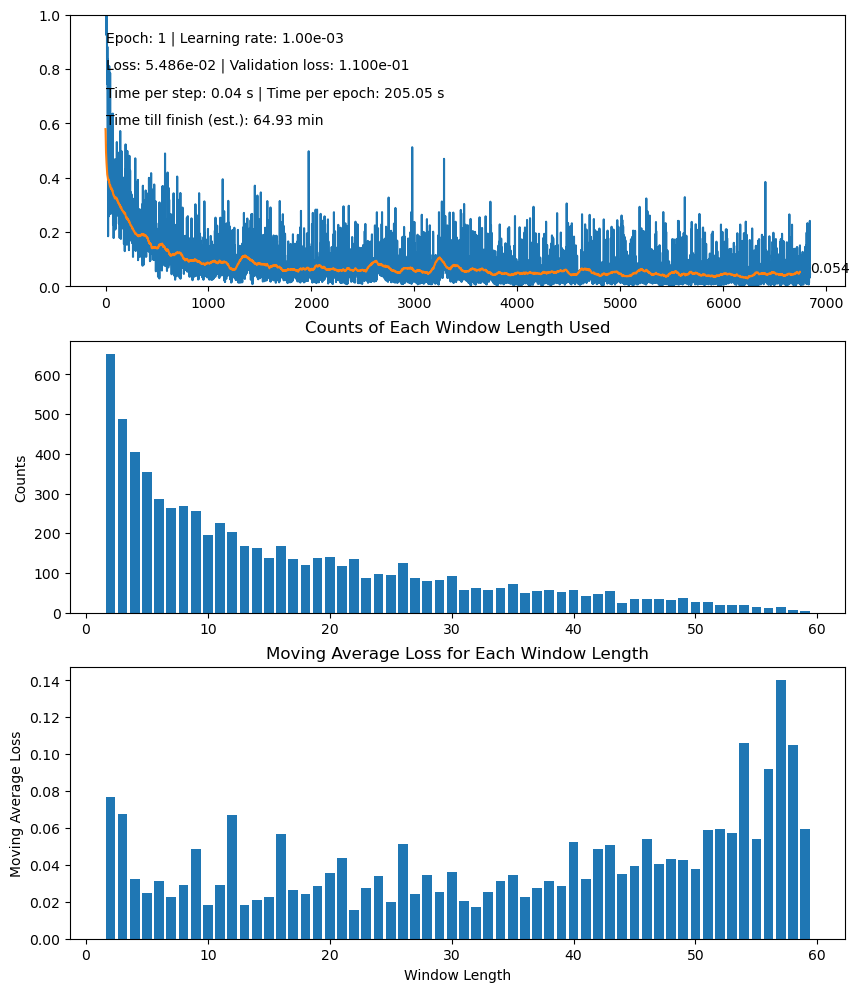

In [49]:
train(
    diffusion_imputer,
    train_loader,
    val_loader,
    num_gpus=1,
    batch_embedder=None,
    gradient_clip=None,
    windowed_mode=True,
    window_mode="biased_loss",
    window_start_mode="fixed",
    train_on_all_every=100,
    min_window=2,
    max_window=59,
    device="cuda",
    epochs=20,
    lr=1e-3,
    annealing_mode=True,
    annealing_window=2,
    annealing_multiplier=1.0,
    annealing_ratio=0.2,
    annealing_minimum=1e-7,
    loss_func=diffusion_imputer.loss_func,
    validation_frequency=2,
    validation_prp=1,
    verbose=False,
    plot_every=100,
)

In [ ]:
# train_hybrid(
#     diffusion_imputer,
#     hybrid_model,
#     train_loader,
#     val_loader,
#     batch_embedder = embedder,
#     epochs = 20,
#     lr = 0.001,
#     annealing_window = 5,
#     annealing_multiplier = 1,
#     loss_func = diffusion_imputer.loss_func,
#     hybrid_loss_func = hybrid_model.loss_func,
#     hybrid_start_epoch = 0,
#     hybrid_every_n_epoch = 5,
#     validation_frequency=2,
#     validation_prp=1)

In [70]:
# # save the entire model for further training
# torch.save(diffusion_imputer, "diffusion_imputer_cancer_aug9.pt")
# torch.save(data_embedder, "data_embedder_cancer_aug9.pt")

# Evaluation


In [ ]:
import torch


def calculate_quantiles(imputed_samples_tensor, qlist):
    quantiles_imp = []
    for q in qlist:
        quantiles = torch.quantile(
            imputed_samples_tensor, q, dim=0, interpolation="midpoint"
        )
        quantiles_imp.append(quantiles)
    return torch.stack(quantiles_imp, dim=0)


# Calculate RMSE with denormalization


def calculate_rmse(
    final_samples, training_mean, training_std, qlist=[
        0.05, 0.25, 0.50, 0.75, 0.95]
):
    all_data = []
    all_imputed = []
    imputed_samples_list = []
    actual_data_list = []

    # Extract one instance of the actual data and imputation mask
    data_instance, imputation_mask_instance = None, None
    sample_number = len(final_samples)

    for sample in final_samples:
        for imputed_samples, data, imputation_mask, _ in sample:
            # Store imputed samples for quantile calculation
            imputed_samples_list.append(
                imputed_samples[imputation_mask != 0].cpu())
            actual_data_list.append(data[imputation_mask != 0].cpu())
            # Flatten the tensors and filter non-zero mask areas
            all_data.append(data[imputation_mask != 0].cpu())
            all_imputed.append(imputed_samples[imputation_mask != 0].cpu())

    # Concatenate all filtered elements
    all_data = torch.cat(all_data)
    all_imputed = torch.cat(all_imputed)

    # Concatenate all imputed samples and reshape to original dimensions
    imputed_samples_tensor = torch.cat(
        imputed_samples_list).reshape(sample_number, -1)

    # Concatenate all actual data and reshape to original dimensions
    actual_data_tensor = torch.cat(actual_data_list).reshape(sample_number, -1)
    actual_data_tensor = actual_data_tensor[0]

    # Denormalize the data
    all_data = all_data * training_std + training_mean
    all_imputed = all_imputed * training_std + training_mean

    # Calculate RMSE for all imputed values
    rmse = torch.sqrt(torch.mean((all_data - all_imputed) ** 2)).item()
    rmse = rmse / 1150 * 100  # Adjust the RMSE as per your requirement

    # Calculate quantiles
    quantiles_imp = calculate_quantiles(imputed_samples_tensor, qlist)
    medians = quantiles_imp[qlist.index(0.50)]  # Median is the 50th percentile

    # Denormalize the medians
    medians = medians * training_std + training_mean

    # Use the median for the new RMSE calculation
    actual_data_tensor = actual_data_tensor * training_std + training_mean

    # Calculate RMSE with medians
    rmse_median = torch.sqrt(torch.mean(
        (actual_data_tensor - medians) ** 2)).item()
    # Adjust the RMSE as per your requirement
    rmse_median = rmse_median / 1150 * 100

    return rmse, rmse_median

In [ ]:
def run_multiple_evaluations(
    dataloader,
    imputer,
    training_mean,
    training_std,
    sample_number,
    batch_embedder=None,
    old_sample=[],
    min_sequence_len=2,
    max_sequence_len=None,
    scale=1,
    verbose=True,
    show_max_diff=False,
    show_rmse=False,
):
    final_samples = old_sample
    max_seq_len = 0
    total_batches = len(dataloader) * sample_number
    completed_batches = 0
    sample_time = []
    average_sample_time = 0

    for i in range(sample_number):
        sample_start = time.time()
        # print a line to separate the samples
        print("-------------------------------------------------")
        print(f"Running sample {i + 1}/{sample_number}")
        all_samples = []
        for batch_idx, data_batch in enumerate(dataloader):
            # Get the data from the batch (collate_fn returns a tuple)
            data_batch = data_batch.to(imputer.device)
            if batch_embedder is not None:
                data_batch = batch_embedder(data_batch)
            seq_length = data_batch.shape[1]
            if seq_length < min_sequence_len:
                # print(f"Skipping batch {batch_idx + 1} as sequence length is less than {min_sequence_len}")
                completed_batches += 1
                continue
            if max_sequence_len is not None and seq_length > max_sequence_len:
                # print(f"Skipping batch {batch_idx + 1} as sequence length is greater than {max_sequence_len}")
                completed_batches += 1
                continue

            print(f"sequence length: {seq_length}")

            # Generate imputation masks for the current batch
            imputation_masks = imputer.get_mask(
                data_batch, strategy="selected_features_last_n_time"
            ).to(imputer.device)

            imputed_samples = imputer.eval(
                data_batch,
                imputation_masks,
                mean=training_mean,
                std=training_std,
                scale=scale,
                verbose=verbose,
                show_max_diff=show_max_diff,
                show_rmse=show_rmse,
            )

            all_samples.append(imputed_samples)

            completed_batches += 1
            progress = completed_batches / total_batches
            print(f"Overall Progress: {progress * 100:.2f}%")
            print(
                f"Time to finish (est.): {average_sample_time * (sample_number - i - 1) / 60:.2f} min"
            )

        sample_end = time.time()
        sample_time.append(sample_end - sample_start)
        average_sample_time = sum(sample_time) / len(sample_time)
        final_samples.append(all_samples)

        rmse, rmse_median = calculate_rmse(
            final_samples, training_mean, training_std)
        print(f"RMSE: {rmse:.3f} | RMSE (Median): {rmse_median:.3f}")

    return final_samples

In [53]:
# diffusion_imputer = torch.load("diffusion_imputer_cancer_jul23.pt")
# data_embedder = torch.load("data_embedder_cancer_jul23.pt")

In [54]:
test_loader = create_dataloader(
    test_data_counterfactuals_tensor,
    test_data_counterfactuals_sequence_lengths,
    batch_size=10000,
    min_seq_length=20,
    max_seq_length=20,
)

print(f"Number of batches in test loader: {len(test_loader)}")

Number of batches in test loader: 1


In [55]:
diffusion_imputer.features_to_impute = [3]
diffusion_imputer.last_n_time = 1

In [56]:
training_standard_deviation = stds["cancer_volume"]
training_mean = means["cancer_volume"]

training_standard_deviation
training_mean

np.float64(39.31261593724658)

np.float64(11.007834958263928)

In [57]:
import gc

torch.cuda.empty_cache()
gc.collect()

38029

In [58]:
# # change working directory
# os.chdir("/work/postresearch/Shared/Researchers/Farbod/cancer/")
# sys.path.append(os.getcwd())

In [59]:
sample_number = 20
final_samples = run_multiple_evaluations(
    dataloader=test_loader,
    imputer=diffusion_imputer,
    batch_embedder=None,
    training_mean=training_mean,
    training_std=training_standard_deviation,
    old_sample=[],  # final_samples,
    # min_sequence_len=2,
    # max_sequence_len=2,
    sample_number=sample_number,
    scale=1,
)

# Set the start method to 'spawn' for the notebook environment

# from custom_classes_and_functions import * #wrapper_run_multiple_evaluations, create_dataloader, load_diffusion_imputer, diffusion_imputation, ModelLoop, DiffusionEmbedding, TimeEmbedding

# import numpy as np
# os.environ['MKL_THREADING_LAYER'] = 'GNU'

# import multiprocessing as mp
# mp.set_start_method('spawn', force=True)

# import os
# import sys

# # Ensure the current directory is in sys.path

# # Define your dataloader
# test_loader = create_dataloader(
#     test_data_counterfactuals_tensor, test_data_counterfactuals_sequence_lengths, batch_size=10000, min_seq_length=2, max_seq_length=2)

# diffusion_imputer = load_diffusion_imputer("diffusion_imputer_cancer_jul23.pt")

# # Assuming other necessary objects are defined (`diffusion_imputer`, `training_mean`, `training_standard_deviation`)
# if __name__ == "__main__":
#     diffusion_imputer =  diffusion_imputer # Initialize your imputer with appropriate parameters
#     final_samples = wrapper_run_multiple_evaluations(
#         dataloader=test_loader,
#         imputer=diffusion_imputer,
#         training_mean=training_mean,
#         training_std=training_standard_deviation,
#         sample_number=6,
#         num_gpus=3
#     )

-------------------------------------------------
Running sample 1/20
sequence length: 20
mae =  1.1894255876541138
Overall Progress: 5.00%
Time to finish (est.): 0.00 min
RMSE: 11.481 | RMSE (Median): 11.481
-------------------------------------------------
Running sample 2/20
sequence length: 20
mae =  1.2223831415176392
Overall Progress: 10.00%
Time to finish (est.): 1.63 min
RMSE: 11.630 | RMSE (Median): 11.176
-------------------------------------------------
Running sample 3/20
sequence length: 20
mae =  1.2284389734268188
Overall Progress: 15.00%
Time to finish (est.): 1.53 min
RMSE: 11.678 | RMSE (Median): 10.971
-------------------------------------------------
Running sample 4/20
sequence length: 20
mae =  1.1940314769744873
Overall Progress: 20.00%
Time to finish (est.): 1.44 min
RMSE: 11.613 | RMSE (Median): 10.941
-------------------------------------------------
Running sample 5/20
sequence length: 20
mae =  1.1930040121078491
Overall Progress: 25.00%
Time to finish (est.

In [ ]:
# save the final samples
# torch.save(final_samples, "final_samples_cancer_jul23.pt")
# final_samples = torch.load("final_samples_cancer_jul20.pt")

In [ ]:
len(final_samples)

100

In [ ]:
# Calculate RMSE
rmse, rmse_median = calculate_rmse(
    final_samples, training_mean, training_standard_deviation
)
print(f"RMSE: {rmse}")
print(f"RMSE using median: {rmse_median}")

RMSE: 20.37842858355978
RMSE using median: 6.875697260317596


In [ ]:
# def quantile_loss(target, forecast, q: float, eval_points) -> float:
#     return 2 * torch.sum(
#         torch.abs((forecast - target) * eval_points * ((target <= forecast) * 1.0 - q))
#     )


# def calc_denominator(target, eval_points):
#     return torch.sum(torch.abs(target * eval_points))


# def calc_quantile_CRPS(target, forecast, eval_points, mean_scaler, scaler):
#     target = target * scaler + mean_scaler
#     forecast = forecast * scaler + mean_scaler

#     quantiles = np.arange(0.05, 1.0, 0.05)
#     denom = calc_denominator(target, eval_points)
#     CRPS = 0
#     for i in range(len(quantiles)):
#         q_pred = []
#         for j in range(len(forecast)):
#             q_pred.append(torch.quantile(forecast[j : j + 1], quantiles[i], dim=1))
#         q_pred = torch.cat(q_pred, 0)
#         q_loss = quantile_loss(target, q_pred, quantiles[i], eval_points)
#         CRPS += q_loss / denom
#     return CRPS.item() / len(quantiles)

In [ ]:
# sample_number = 100

In [ ]:
# all_target = samples[0][1]  # input_data same for all samples (B, L, K)
# all_generated_samples = torch.stack([samples[i][0] for i in range(sample_number)]).permute(1,0,2,3)  # (B, sample_num, L, K)
# all_evalpoint = samples[0][2]  # mask same for all samples (B, L, K)
# CRPS = calc_quantile_CRPS(all_target, all_generated_samples, all_evalpoint, training_mean, training_standard_deviation)
# print(CRPS)

In [ ]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "last_expr"

In [ ]:
# L = test_data.shape[1]
# K = test_data.shape[2]

# dataind = 40  # Number of samples to visualize
# start_time = 40
# n_skip = 0  # Number of columns to skip

# plt.rcParams["font.size"] = 16
# fig, axes = plt.subplots(nrows=dataind, ncols=K - n_skip, figsize=(24.0, 6 * dataind))

# for i in range(dataind):
#     for k in range(n_skip, K):  # Start from n_skip instead of 0
#         df = pd.DataFrame({
#             "x": np.arange(start_time, L),
#             "val": denormed_data[i, start_time:, k],
#             "y": eval_points[i, start_time:, k]
#         })
#         df = df[df.y != 0]
#         df2 = pd.DataFrame({
#             "x": np.arange(start_time, L),
#             "val": denormed_data[i, start_time:, k],
#             "y": given_points[i, start_time:, k]
#         })
#         df2 = df2[df2.y != 0]
#         indices = df.x.astype(int).to_numpy()
#         row = i
#         col = k - n_skip  # Adjust column index for skipped columns

#         axes[row][col].plot(range(start_time, L), quantiles_imp[2][i, start_time:, k], color='g', linestyle='solid', label='median')
#         axes[row][col].fill_between(range(start_time, L), quantiles_imp[0][i, start_time:, k], quantiles_imp[4][i, start_time:, k], color='g', alpha=0.3)
#         axes[row][col].plot(df.x, df.val, color='b', marker='o', linestyle='None')
#         axes[row][col].plot(df.x, quantiles_imp[5][i, indices, k], color='r', linestyle='None', label='median', marker='x')
#         axes[row][col].plot(df.x, quantiles_imp[0][i, indices, k], color='r', linestyle='None', marker=1)
#         axes[row][col].plot(df.x, quantiles_imp[4][i, indices, k], color='r', linestyle='None', marker=1)

#         if col == 0:  # Only label the first of the remaining columns
#             axes[row][col].set_ylabel('Value')
#         if row == dataind - 1:  # Only label the last row
#             axes[row][col].set_xlabel('Time')

# # Optional: Adjust the layout for better spacing
# plt.tight_layout()
# plt.show()